# ***Askle***, a fully automated AI Research Agent for Medical Researchers

#### *Tiange (Alex) Cui*, April 2025
<br>

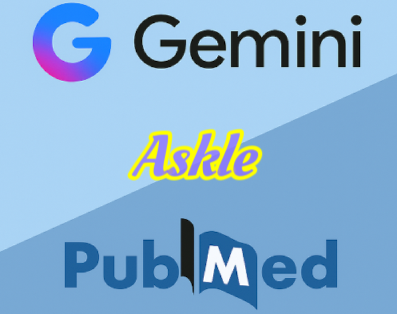

## Background

The rapid proliferation of scientific literature presents a significant challenge for researchers seeking to stay current. This project leverages an AI agent powered by Large Language Models (**Gemini**) to accelerate knowledge synthesis by automatically retrieving, processing, and summarizing relevant publications and guidelines. Google's Gemini models are particularly well-suited, offering extensive context windows to analyze numerous documents simultaneously, advanced reasoning for nuanced synthesis beyond simple summarization, and robust API features like function calling and structured output for seamless integration with external tools and databases (e.g., **PubMed**). By combining Gemini with **Retrieval-Augmented Generation (RAG)** and structured data storage, this agent aims to provide researchers with efficient, grounded, and comprehensive overviews of current research landscapes.

<br>

## Project Goal
To create an AI agent, ***Askle***, the system takes a user’s question—typically medical or research-focused—retrieves the most relevant and recent scientific literature along with supplementary materials such as clinical guidelines and expert consensus documents, and synthesizes the information into a comprehensive, well-referenced answer reflecting the latest research developments.

<br>

## Project Highlights
***Askle*** empowers medical professionals and researchers to get instant, evidence-based answers without manually sifting through countless research papers. With seamless integration of medical guidelines and expert consensus via an easy-to-extend RAG system, users can ground insights in real-world clinical standards. Its modular, developer-friendly design enables rapid transformation into powerful AI agents for advanced workflows. Best of all, Askle operates without external API calls—dramatically reducing token costs and making it highly scalable from day one!

<br>

## Workflow

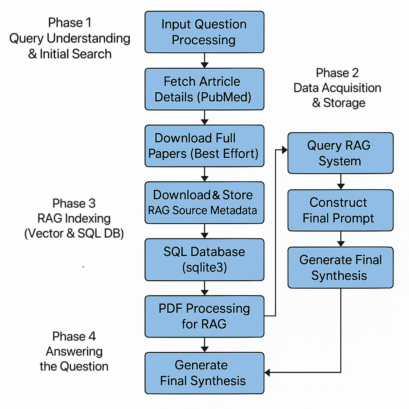o

<br>

## Section I. Environment Setup & Function Defination
### - Install Prerequisite Python Libraries

In [1]:
!pip install -U -q "google-genai==1.7.0" "chromadb==0.6.3" google-api-core google-cloud-automl google-cloud-translate biopython PyMuPDF sqlalchemy requests beautifulsoup4 PyPDF2 ibis-framework gcsfs bigframes > /kaggle/working/log.txt 2>&1 

### - Import Libraries & Setup Variables 

- Provided `GOOGLE_API_KEY`
- Chose `gemini-2.0-flash-exp` as the Gemini model
- Chose `text-embedding-004` as the embedding model
- Defined Stop Words List for Text Processing
- Configured SQL Database
- Configured ChromaDB Vector Database

In [2]:
import re
import os
import sys
import fitz
import time
import json
import sqlite3
import requests
import chromadb
from Bio import Entrez
from bs4 import BeautifulSoup
from typing import Callable, Dict, List, Tuple, Optional
from IPython.display import Markdown, display, clear_output
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

from google import genai
from google.genai import types
from google.api_core import retry
is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})
genai.models.Models.generate_content = retry.Retry(
    predicate=is_retriable)(genai.models.Models.generate_content)


from kaggle_secrets import UserSecretsClient
GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
if not GOOGLE_API_KEY:
    raise ValueError("⚠️ Please set your GOOGLE_API_KEY environment variable in Kaggle Secrets to run this notebook.")
else:
    print("✅ Google API Key is set up, Google Gen AI SDK is ready.")


# Setup Model Parameters
workdir = "/kaggle/working"
GENERATIVE_MODEL = "gemini-2.0-flash-exp"
EMBEDDING_MODEL = "models/text-embedding-004"
EMBEDDING_BATCH_SIZE = 50

client = genai.Client(api_key=GOOGLE_API_KEY)
chat = client.chats.create(model=GENERATIVE_MODEL, history=[])


# Get customized basic English stop words 
custom_stop_words = [
    "source", "vs", "from", "analysis", "study", "review", "comparison", "efficacy",
    "trial", "guidelines", "inhibitor", "therapy", "treatment", "lung", "cancer",
    "cell", "non-small", "advanced", "metastatic", "patients"]
STOP_WORDS = ENGLISH_STOP_WORDS.union(custom_stop_words)


# Database Configuration
Entrez.email = "mock_email@gmail.com" 
DATABASE_NAME = "pubmed_papers.db"
TABLE_NAME = 'papers'


# RAG Configuration
RAG_DIR = "/kaggle/working/rag"
os.makedirs(RAG_DIR, exist_ok=True)
CHROMA_COLLECTION = "pdf_chunks_embeddings"
CHROMA_STORAGE_MODE = "persistent"
CHROMA_PERSIST_DIR = os.path.join(workdir, "chroma_persistent_db")

# Ensure the target directory exists before initializing client
try:
    # exist_ok=True prevents error if directory already exists
    os.makedirs(CHROMA_PERSIST_DIR, exist_ok=True)
except OSError as e:
    print(f"❌ Error creating/accessing persistence directory '{CHROMA_PERSIST_DIR}'. Cannot initialize persistent client.: {e}")
    # Exit here because persistent mode was explicitly requested but cannot be fulfilled
    sys.exit("❗❌ ChromaDB persistence directory error.")

# Try initializing the persistent client
try:
    chroma_client = chromadb.PersistentClient(path=CHROMA_PERSIST_DIR)
    print("✅ Persistent ChromaDB client initialized successfully!")
except Exception as e:
    print(f"❌ FATAL: Failed to initialize persistent ChromaDB client at '{CHROMA_PERSIST_DIR}': {e}")
    chroma_client = None
    # Exit here because persistent mode was explicitly requested but failed
    sys.exit("❗❌ ChromaDB persistent client initialization failed.")


✅ Google API Key is set up, Google Gen AI SDK is ready.
✅ Persistent ChromaDB client initialized successfully!


### - Define A Collection of Helper Functions

- `sanitize_input` <br>
  A function call to use Gemini to sanitize the user's input question.
- `extract_keywords_json` <br>
  Extracts keywords from the sanitized question using Gemini with few-shot prompting and outputs them in JSON format.
- `search_pubmed` <br>
  Searches PubMed using keywords and retrieves a specified number of articles, sorted by the given criteria.
- `get_pubmed_article_details` <br>
  Use a list of PubMed IDs to fetch detailed information (title, abstract, authors, journal, publication date, url, etc).
- `download_paper` <br>
  Ensures paper metadata is saved/updated in the DB via `upsert_paper_metadata`. Then, attempt to download the PDF from PMC if possible.
- `upsert_paper_metadata` <br>
  Inserts paper metadata if it doesn't exist (based on pubmed_id), or updates the existing metadata if it does.
- `upsert_paper_metadata_by_pmid` <br>
  Inserts paper metadata if the pubmed_id doesn't exist, or updates existing metadata if it does.
- `create_papers_table` <br>
  Creates the 'papers' table in the database.
- `insert_paper_data` <br>
  Inserts paper data into the 'papers' table, ignoring if PMID already exists.
- `rag_downloader` <br>
  Downloads a PDF file from a URL and saves it to the specified location.
- `add_paper_by_pmid` <br>
  Fetches paper details from PubMed using PMID, then adds or updates the metadata in the SQLite table using an upsert operation based on PMID.
- `delete_paper_by_pmid` <br>
  Deletes paper entries from the specified SQLite table based on PubMed ID.
- `fetch_paper_data_by_pmid` <br>
  Fetches paper data from the database for a given PMID.
- `fetch_abstracts_from_db` <br>
  Fetches all non-NULL abstracts from the papers table.
- `extract_text_from_pdf` <br>
  Extracts text content from a PDF file.
- `chunk_text` <br>
  Splits text into smaller chunks with overlap.
- `generate_embeddings` <br>
  Function calls to generate embeddings using the Gemini.
- `process_papers_for_rag_persistent` <br>
  Uses a persistent ChromaDB client. Gets/Creates the collection. Processes PDFs from download_dir, skipping those already fully represented in the collection based on metadata 'source' check. Upserts new chunk data.
- `query_rag_system` <br>
  Embeds query using Client API and searches the RAG collection.
- `get_keywords` <br>
  Extracts simple keywords from text, removing stop words and short words.
- `find_best_match_keywords` <br>
  Finds the best matching paper based on keyword overlap between the tag text and the paper's title AND abstract.
- `add_references_to_summary` <br>
  Adds numerical references [N] by matching (Source: ...) tags via filename OR keyword overlap with title/abstract. Then, append reference list.The e
- `evaluate_summary_with_llm` <br>
  The evaluation agent, functions as an LLM-as-Judge for a two-step evaluation process: verbose reasoning + structured JSON ratings.
  
All the functions are listed below:

In [3]:
# Hide for better visual

def sanitize_input(user_question: str) -> str:
    """
    Sanitizes the user's input question using Gemini.
    """
    prompt = f"""You are a helpful assistant that cleans and prepares user questions for further processing.

    User Question: "{user_question}"

    Sanitized Question:"""
    response = chat.send_message(prompt)
    return response.text.strip()


def extract_keywords_json(sanitized_question: str) -> dict:
    """
    Extracts keywords from the sanitized question using Gemini with few-shot prompting
    and outputs them in JSON format.
    """
    prompt = f"""You are an expert at extracting relevant keywords from text for search queries.
    Your output should be a JSON object with a single key "keywords" and its value as a list of strings.

    Here are a few examples:

    User Question: "What are the latest treatments for rheumatoid arthritis?"
    {{
      "keywords": ["latest treatments", "rheumatoid arthritis"]
    }}

    User Question: "Find me research articles on the impact of exercise on cognitive function in older adults."
    {{
      "keywords": ["impact of exercise", "cognitive function", "older adults"]
    }}

    User Question: "Tell me about the genetic basis of Alzheimer's disease."
    {{
      "keywords": ["genetic basis", "Alzheimer's disease"]
    }}

    User Question: "{sanitized_question}"
    {{
      "keywords":"""
    response = client.models.generate_content(
        model='gemini-2.0-flash',
        contents= prompt,
        config={'response_mime_type': 'application/json'}
    )
    try:
        return json.loads(response.text)
    except json.JSONDecodeError as e:
        print(f"❌ Error decoding JSON: {e}")
        print(f"Raw response: {response.text}")
        return {"keywords": []}


def search_pubmed(keywords: list, retmax: int = 5, sort_by: str = "relevance") -> list:
    """
    Searches PubMed using keywords and retrieves a specified number of articles,
    sorted by the given criteria.
    """
    sort_options = ["relevance", "date"]
    if sort_by not in sort_options:
        raise ValueError(f"❌ Invalid sort_by option. Choose from: {sort_options}")

    try:
        handle = Entrez.esearch(
            db="pubmed",
            term=" AND ".join(keywords),
            retmax=retmax,
            sort=sort_by,
        )
        record = Entrez.read(handle)
        handle.close()
        return record["IdList"]
    except Exception as e:
        print(f"❌ Error searching PubMed for {sort_by}: {e}")
        return []


def get_pubmed_article_details(id_list: list) -> list:
    """
    Fetches detailed information (title, abstract, authors, journal, publication date, url)
    for a list of PubMed IDs.
    """
    details = []
    try:
        handle = Entrez.efetch(db="pubmed", id=id_list, rettype="medline", retmode="xml")
        records = Entrez.read(handle)

        citation_handle = Entrez.elink(dbfrom="pubmed", db="pmc", id=id_list, linktype="citedby")
        citation_record = Entrez.read(citation_handle)
        citation_counts = {linksetdb['IdList'][0]: len(linksetdb.get('LinkSetDb', []))
                           for linksetdb in citation_record if linksetdb.get('LinkSetDb')}
        citation_handle.close()

        for record in records['PubmedArticle']:
            article = record['MedlineCitation']['Article']

            authors = []
            authors_affiliations = []
            for author_data in article.get('AuthorList', []):
                if isinstance(author_data, dict):  # Check if it's a dictionary
                    author_name = f"{author_data.get('LastName', 'N/A')} {author_data.get('ForeName', 'N/A')}"
                    authors.append(author_name)

                    affiliation_strings = []  # List to store affiliations for this author
                    for affiliation_info in author_data.get('AffiliationInfo', []):
                        affiliation = affiliation_info.get('Affiliation', 'N/A')
                        affiliation_strings.append(affiliation)
                    authors_affiliations.append('; '.join(affiliation_strings) if affiliation_strings else 'N/A')  # Join affiliations with semicolon
                elif isinstance(author_data, Entrez.Parser.DictionaryElement):  # Or an Entrez DictionaryElement
                    author_name = f"{author_data.get('LastName', 'N/A')} {author_data.get('ForeName', 'N/A')}"
                    authors.append(author_name)
                    authors_affiliations.append('N/A')
                else:
                    authors.append('N/A')
                    authors_affiliations.append('N/A')


            publication_date_data = article.get('Journal', {}).get('JournalIssue', {}).get('PubDate', {})
            publication_date = f"{publication_date_data.get('Year', 'N/A')}-{publication_date_data.get('Month', 'N/A')}-{publication_date_data.get('Day', 'N/A')}"

            abstract_parts = article.get('Abstract', {}).get('AbstractText', [])
            abstract = ' '.join(part for part in abstract_parts if isinstance(part, str))

            pmid = record['MedlineCitation']['PMID']
            if isinstance(pmid, str):
                pmid_string = pmid
            else:
                pmid_string = str(pmid)
            
            url = f"https://pubmed.ncbi.nlm.nih.gov/{pmid}/"
            citation_number = citation_counts.get(pmid, 0)

            details.append({
                "title": article.get('ArticleTitle', 'N/A'),
                "authors": ', '.join(authors) if authors else 'N/A',
                "authors_affiliation": ', '.join(authors_affiliations) if authors_affiliations else 'N/A',
                "journal": article.get('Journal', {}).get('Title', 'N/A'),
                "publication_date": publication_date,
                "citation_count": citation_number,
                "pubmed_id": pmid if pmid else 'N/A',
                "abstract": abstract if abstract else 'N/A',
                "url": url
            })
        return details
    except Exception as e:
        print(f"❌ Error fetching PubMed article details: {e}")
        return []


def download_paper(article_data: dict, conn: sqlite3.Connection, download_dir: str = workdir) -> str:
    """
    Ensures paper metadata is saved/updated in the DB via upsert.
    Then, attempts to download the PDF from PMC if possible (requires PMID).
    Returns the download file path (str) on success, None otherwise.

    Args:
        article_data: A dictionary containing the article's metadata.
        conn: The SQLite database connection.
        download_dir: The directory to save the downloaded paper.
    """
    # title = article_data["title"]
    # pmid = article_data["url"].split("/")[-2]  # Extract PMID from URL
    # article_data["pubmed_id"] = pmid
    # This happens regardless of download possibility or outcome
    # upsert_paper_metadata(conn, article_data)
    
    pmid = article_data.get("pubmed_id") # Try direct key first

    if not pmid and "url" in article_data and isinstance(article_data.get("url"), str) and "pubmed.ncbi.nlm.nih.gov" in article_data["url"]:
        print(f"   Attempting to extract PMID from URL as 'pubmed_id' key was missing or empty...")
        try:
            # Extract potential ID - assumes format https://.../PMID/
            potential_pmid = article_data["url"].strip().rstrip('/').split('/')[-1]
            if potential_pmid.isdigit(): # Basic validation it's numeric
                pmid = potential_pmid
                article_data["pubmed_id"] = pmid # Add back to dict for upsert
                print(f"   Extracted PMID {pmid} from URL.")
            else:
                print(f"   ⚠️ Extracted value '{potential_pmid}' from URL does not look like a valid PMID.")
        except Exception as e_parse:
            print(f"   ⚠️ Error parsing PMID from URL '{article_data.get('url')}': {e_parse}")

    # Check if we have a usable PMID before upserting
    if not pmid:
         print(f"❌ CRITICAL: Cannot proceed without a valid PMID for title '{title[:50]}...'. Skipping upsert and download.")
         return None # Cannot even save metadata reliably without a key

    try:
        # Pass the potentially modified article_data (with pmid added)
        upsert_paper_metadata(conn, article_data)
    except Exception as e_upsert_call:
        print(f"   ❌ CRITICAL Error occurred *calling* upsert_paper_metadata: {e_upsert_call}")
        return None

    print(f"  ➡️ Proceeding to PDF download check for PMID: {pmid}")
    if not pmid:
        print(f"❗❌ No valid PMID. Download cannot proceed for: [{title[:20]}].")
    
    cursor = conn.cursor() 

    # Check if paper exists and maybe already downloaded
    try:
        cursor.execute(f"SELECT pdf_path FROM {TABLE_NAME} WHERE pubmed_id = ?", (pmid,))
        result = cursor.fetchone()
        if result and result[0] and os.path.exists(result[0]):
            print(f"    ✅ PDF already downloaded at: {result[0]}. Download skipped.")
            return result[0] # Already done
        elif result and result[0]:
            print(f"   ⚠️ DB lists file path, but file not found. Attempting download.")
    except sqlite3.Error as e:
         print(f"    ❌ DB Error checking pdf_path: {e}. Download skipped.")
         return None # Safer to return None if DB check fails
        
    # Attempt Download only if PMID exists and download needed
    print(f"    ⏳ Searching for {pmid}...")
    download_location = None
    headers = {"User-Agent": "Mozilla/5.0 (compatible; MyResearchBot/1.0; +http://askle.com/downloader)"}
    pmc_id = None

    try:
       # Find PMC_ID
        try:
            # Using Entrez esearch to get PMC ID
            handle = Entrez.esearch(db="pmc", term=pmid, retmax=1)
            pmc_record = Entrez.read(handle)
            handle.close()
            if pmc_record["IdList"]:
                pmc_id = pmc_record["IdList"][0]
            else:
                # Try ID converter if esearch fails
                base_url = "https://www.ncbi.nlm.nih.gov/pmc/utils/idconv/v1.0/"
                tool = "askle_pmc_downloader"
                email = Entrez.email
                url = f"{base_url}?tool={tool}&email={email}&ids={pmid}&idtype=pmid&format=json"
                try:
                    response = requests.get(url, timeout=5)
                    response.raise_for_status()
                    data = json.loads(response.text)
                    if data and data["records"] and "pmcid" in data["records"][0]:
                        pmc_id = data["records"][0]["pmcid"]
                except (requests.exceptions.RequestException, json.JSONDecodeError, KeyError, IndexError) as e:
                    print(f" ❌  PMC ID conversion request failed {e}")
        except Exception as e_entrez:
             print(f" ❌ Error During PMID Conversion: {e_entrez}")

        # Attempt Download if PMC ID Found
        if pmc_id:
            print(f"      █▒▒▒▒▒ Attempting download from PMC ({pmid})")
            
            # Standardize ID format for filename and URL
            if not pmid.startswith("PMC"):
                 filename = f"PMC{pmid}"
            else:
                 filename = pmid

            if not pmc_id.startswith("PMC"):
                 filename_pmc_id = f"PMC{pmc_id}"
            else:
                 filename_pmc_id = pmc_id

            fn = os.path.join(download_dir, f"{filename}.pdf")
            
            # Check again if file exists (might have been created between initial check and now)
            if os.path.exists(fn):
                 print(f"      ⚠️ File {fn} exists, updating database...")
                 download_location = fn
                 cursor.execute(f"UPDATE {TABLE_NAME} SET pdf_path = ? WHERE pubmed_id = ? AND (pdf_path IS NULL OR pdf_path != ?)", (download_location, pmid, download_location))
                 conn.commit()
                 return download_location

            try:
                time.sleep(1)
                pmc_url = f"https://www.ncbi.nlm.nih.gov/pmc/articles/{filename_pmc_id}/pdf/"
                response = requests.get(pmc_url, headers=headers, timeout=10, allow_redirects=True)
                response.raise_for_status()

                # Check if content looks like a PDF before saving
                os.makedirs(download_dir, exist_ok=True) # Ensure directory exists
                with open(fn, "wb") as f:
                    f.write(response.content)
                print(f"       ✅ Successfully saved PDF to: {workdir}")
                download_location = filename

                # Update database ONLY on successful download
                cursor.execute(f"UPDATE {TABLE_NAME} SET pdf_path = ? WHERE pubmed_id = ?", (download_location, pmid))
                conn.commit()
                print(f"       ✅ Saved {pmid} to SQL database.")
                return download_location
    
            except requests.exceptions.HTTPError as http_err:
                 print(f"     ❌ PMC Download HTTP Error for {pmid}: {http_err.response.status_code} {http_err}")
            except requests.exceptions.RequestException as req_err:
                print(f"     ❌ PMC Download Request Failed for {pmid}: {req_err}")
            except Exception as e_down:
                print(f"     ❌ Unexpected error during PMC download for {pmid}): {e_down}")
                # Leave pdf_path as NULL in DB
        else:
            print(f"      ❌ Paper {pmid} not found on PMC database. No download attempted.❗")
            # Leave pdf_path as NULL in DB

        # *** NO UPDATE TO 'N/A' HERE *** pdf_path remains NULL. Return None indicating failure
        return None  
        
    except Exception as e_outer:
        print(f"     ❌ Download unsuccessful for PMID {pmid} ('{title[:50]}...'): {e_outer}")
        # Ensure pdf_path remains NULL or handle appropriately. Return None on outer error
        return None


def upsert_paper_metadata(conn: sqlite3.Connection, paper_data: Dict) -> None:
    """
    Inserts paper metadata if it doesn't exist (based on pubmed_id),
    or updates the existing metadata if it does.
    Handles cases where pubmed_id might be None (but update won't work without it).
    """
    cursor = conn.cursor()
    pmid = paper_data.get("pubmed_id") # Can be None

    # Exclude pdf_path from the update part, as it's handled separately by download logic
    # List columns in the order they appear in the table (excluding id and pdf_path for update)
    columns_to_upsert = [
        "title", "authors", "authors_affiliation", "journal",
        "publication_date", "citation_count", "pubmed_id", "abstract", "url"
    ]
    # Get corresponding values, using None if key is missing in paper_data
    values_to_upsert = [paper_data.get(col) for col in columns_to_upsert]

    # Ensure pubmed_id is included correctly, even if None
    if "pubmed_id" not in columns_to_upsert:
         # This should not happen based on the list above, but as a safeguard:
         columns_to_upsert.append("pubmed_id")
         values_to_upsert.append(pmid)
    else:
         # Ensure the value for pubmed_id in the list matches the variable
         try:
            pmid_index = columns_to_upsert.index("pubmed_id")
            values_to_upsert[pmid_index] = pmid
         except ValueError:
             pass # Should not happen


    # Prepare column names for SET clause in UPDATE
    update_set_clause = ", ".join([f"{col} = excluded.{col}" for col in columns_to_upsert if col != "pubmed_id"])

    # Use placeholders for values
    placeholders = ", ".join(["?"] * len(columns_to_upsert))
    column_names = ", ".join(columns_to_upsert)

    # Add pdf_path column for INSERT, but set it to NULL initially if not provided
    if "pdf_path" not in columns_to_upsert:
        column_names += ", pdf_path"
        placeholders += ", ?"
        values_to_upsert.append(paper_data.get("pdf_path")) # Usually None on first pass

    sql = f"""
        INSERT INTO {TABLE_NAME} ({column_names})
        VALUES ({placeholders})
        ON CONFLICT(pubmed_id) WHERE pubmed_id IS NOT NULL DO UPDATE SET
            {update_set_clause}
    """
    # Handle the case where pmid IS NULL - INSERT will work, ON CONFLICT won't trigger for the NULL case
    # If multiple entries lack a PMID, this won't update them based on conflict.
    # If you need to update entries where pmid IS NULL based on other fields (e.g., title),
    # the logic becomes much more complex. Assuming PMID is the primary conflict target.

    try:
        # print(f"DEBUG UPSERT SQL: {sql}") # Uncomment for debugging SQL
        # print(f"DEBUG UPSERT Values: {values_to_upsert}") # Uncomment for debugging values
        cursor.execute(sql, values_to_upsert)
        conn.commit()
        print(f"✅ Metadata upserted for PMID: {pmid if pmid else 'N/A'} ('{paper_data.get('title', '')[:30]}...')")
    except sqlite3.Error as e:
        print(f"❌ Error during metadata upsert for PMID {pmid if pmid else 'N/A'}: {e}")
    except Exception as e_global:
        print(f"❌ Unexpected error during upsert_paper_metadata (PMID: {pmid if pmid else 'N/A'}): {e_global}")


def upsert_paper_metadata_by_pmid(conn: sqlite3.Connection, paper_data: Dict) -> None:
    """
    Inserts paper metadata if the pubmed_id doesn't exist,
    or updates existing metadata if it does (based on pubmed_id).
    Requires pubmed_id column to have a UNIQUE constraint.
    Sets pdf_path to NULL if not provided in paper_data.
    """
    cursor = conn.cursor()
    pmid = paper_data.get("pubmed_id")

    # This function relies on a non-null PMID for upsert logic
    if not pmid:
        print("⚠️ Warning: upsert_paper_metadata_by_pmid called without a PMID. Skipping upsert.")
        # If you need to handle inserting records without PMIDs elsewhere,
        # use a different function or logic (e.g., simple INSERT or upsert on pdf_path).
        return

    # Define columns for INSERT/UPDATE
    # Ensure order matches table schema for clarity if possible
    columns_for_insert = [
        "title", "authors", "authors_affiliation", "journal", "publication_date",
        "citation_count", "pubmed_id", "abstract", "url", "pdf_path" # Include pdf_path
    ]
    # Use .get() for safety, provide default None for pdf_path if missing
    values_for_insert = [paper_data.get(col) for col in columns_for_insert[:-1]] # Get all except pdf_path
    values_for_insert.append(paper_data.get("pdf_path")) # Add pdf_path (will be None if not set)

    # Define columns for UPDATE SET clause
    # Exclude id, the conflict key pubmed_id, and usually pdf_path
    # (pdf_path update should happen after successful download)
    columns_for_update = [
        "title", "authors", "authors_affiliation", "journal", "publication_date",
        "citation_count", "abstract", "url"
    ]
    # Use SQLite's 'excluded' keyword to refer to values from the conflicting INSERT
    update_set_clause = ", ".join([f"{col} = excluded.{col}" for col in columns_for_update])

    placeholders = ", ".join(["?"] * len(columns_for_insert))
    column_names_insert = ", ".join(columns_for_insert)

    # Use pubmed_id as the conflict target
    # WHERE clause ensures conflict only triggers for actual (non-NULL) PMIDs
    sql = f"""
        INSERT INTO {TABLE_NAME} ({column_names_insert})
        VALUES ({placeholders})
        ON CONFLICT(pubmed_id) WHERE pubmed_id IS NOT NULL DO UPDATE SET
            {update_set_clause}
    """
    try:
        cursor.execute(sql, values_for_insert)
        conn.commit()
        print(f"    ✅ Metadata upserted for PMID: {pmid} ('{paper_data.get('title', '')[:30]}...')")
    except sqlite3.Error as e:
        print(f"    ❌ Error during metadata upsert for PMID {pmid}: {e}")
        # Consider re-raising if failure is critical: raise e
    except Exception as e_global:
        print(f"    ❌ Unexpected error during upsert_paper_metadata_by_pmid (PMID: {pmid}): {e_global}")
        # Consider re-raising: raise e_global


def insert_paper_data(conn: sqlite3.Connection, paper_data: Dict) -> None:
    """Inserts paper data into the 'papers' table, ignoring if PMID already exists."""
    cursor = conn.cursor()
        
    try:
        cursor.execute(f"""
            INSERT OR IGNORE INTO {TABLE_NAME} (title, authors, authors_affiliation, journal, publication_date, citation_count, pubmed_id, abstract, url, pdf_path)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        """, (
            paper_data.get("title"),
            paper_data.get("authors"),
            paper_data.get("authors_affiliation", "N/A"),  # Use get() with default
            paper_data.get("journal"),
            paper_data.get("publication_date"),
            paper_data.get("citation_count"),
            paper_data.get("pubmed_id", "N/A"),
            paper_data.get("abstract"),
            paper_data.get("url"),
            paper_data.get("pdf_path")
        ))
        conn.commit()
    except sqlite3.Error as e:
        print(f"❌ Error inserting paper data: {e}")


def create_papers_table(conn: sqlite3.Connection) -> None:
    """Creates the 'papers' table in the database."""
    cursor = conn.cursor()
    cursor.execute(f"""
        CREATE TABLE IF NOT EXISTS {TABLE_NAME} (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            title TEXT,
            authors TEXT,
            authors_affiliation TEXT,
            journal TEXT,
            publication_date TEXT,
            citation_count INTEGER,
            pubmed_id TEXT UNIQUE,
            abstract TEXT,
            url TEXT,
            pdf_path TEXT UNIQUE)""")
    conn.commit()


def rag_downloader(filename: str, url: str, save_location: str = RAG_DIR) -> str:
    """
    Downloads a PDF file from a URL and saves it to the specified location.
    Args:
        filename (str): Name for the saved file (e.g., 'paper.pdf').
        url (str): Direct URL to the PDF.
        save_location (str): Directory to save the file. Defaults to ragdir (/kaggle/working/rag).

    Returns:
        str: Full path to the saved file.
    """
    os.makedirs(save_location, exist_ok=True)
    save_path = os.path.join(save_location, filename)
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    with open(save_path, "wb") as f:
        f.write(response.content)
    print(f"✅ Downloaded and saved: {save_path}")
    return save_path


def add_paper_by_pmid(pmid: str, conn: sqlite3.Connection) -> bool:
    """
    Fetches paper details from PubMed using PMID, then adds or updates
    the metadata in the SQLite table using an upsert operation based on PMID.

    Args:
        pmid (str): The PubMed ID (as a string) of the paper to add/update.
        conn: An active SQLite database connection.

    Returns:
        bool: True if the metadata was successfully fetched and upserted, False otherwise.
    """
    print(f"\n--- Attempting to add/update paper metadata for PMID: {pmid} ---")

    # 1. Input Validation (Basic)
    if not pmid or not isinstance(pmid, str) or not pmid.strip().isdigit():
        print(f"❌ Invalid PMID provided: '{pmid}'. Must be a non-empty numeric string.")
        return False
    # Clean up pmid just in case
    pmid = pmid.strip()

    # 2. Fetch Details from PubMed
    print(f"   Fetching details from PubMed for PMID: {pmid}...")
    try:
        # Call existing function which expects a list and returns a list
        article_details_list = get_pubmed_article_details([pmid]) # Pass PMID in a list
    except NameError:
         print("   ❌ Error: The function 'get_pubmed_article_details' is not defined.")
         return False
    except Exception as e_fetch:
        print(f"   ❌ Error calling get_pubmed_article_details for PMID {pmid}: {e_fetch}")
        return False

    # 3. Check Fetch Result
    if not article_details_list:
        print(f"   ❌ No details found on PubMed for PMID: {pmid}.")
        return False
    # Optional: Check for multiple results, though unlikely for a single PMID fetch
    # if len(article_details_list) > 1:
    #      print(f"   ⚠️ Warning: Found multiple results for PMID {pmid}. Using the first one.")

    article_data = article_details_list[0] # Get the first (should be only) result

    # Verify the fetched data contains the correct PMID
    fetched_pmid = str(article_data.get("pubmed_id", ""))
    if fetched_pmid != pmid:
         print(f"   ❌ Error: Fetched data's PMID ({fetched_pmid}) does not match requested PMID ({pmid}). Aborting.")
         return False

    # 4. Prepare Data (Ensure pdf_path is initially None)
    # This function focuses on metadata; pdf_path is handled separately
    article_data["pdf_path"] = None # Set pdf_path to None for the initial metadata upsert

    # 5. Upsert Metadata using the PMID-based upsert function
    print(f"   Upserting metadata for PMID: {pmid} into table '{TABLE_NAME}'...")
    try:
        # Use the specific upsert function that targets pubmed_id for conflicts
        upsert_paper_metadata_by_pmid(conn, article_data)
        # Assuming upsert handles its own commit and logging
        print(f"--- Successfully processed metadata for PMID: {pmid} ---")
        return True
    except Exception as e_upsert:
         # Catch errors specifically from the upsert call if needed
         print(f"   ❌ Error occurred during the upsert step for PMID {pmid}: {e_upsert}")
         return False


def delete_paper_by_pmid(pmid: str, conn: sqlite3.Connection, table_name: str = DATABASE_NAME) -> int:
    """
    Deletes paper entries from the specified SQLite table based on PubMed ID.

    Args:
        pmid (str): The PubMed ID (as a string) of the paper entry to delete.
        conn: An active SQLite database connection object.
        table_name (str): The name of the database table. Defaults to 'papers'.

    Returns:
        int: The number of rows deleted. This will be 0 if no matching PMID
             was found, 1 if a match was found and deleted (assuming pubmed_id
             is unique), or potentially >1 if pubmed_id wasn't unique (not recommended).
             Returns -1 if a database error occurred.
    """
    print(f"\n--- Attempting to delete paper entry for PMID: {pmid} from table '{table_name}' ---")

    # 1. Input Validation
    if not pmid or not isinstance(pmid, str) or not pmid.strip().isdigit():
        print(f"❌ Invalid PMID provided: '{pmid}'. Must be a non-empty numeric string.")
        return -1 # Indicate invalid input error

    pmid_to_delete = pmid.strip() # Use cleaned version

    rows_deleted = 0 # Initialize count
    try:
        cursor = conn.cursor()

        # 2. Prepare the SQL DELETE statement using a placeholder
        sql = f"DELETE FROM {table_name} WHERE pubmed_id = ?"

        # 3. Execute the command with the pmid as a parameter
        print(f"   Executing SQL: DELETE FROM {table_name} WHERE pubmed_id = '{pmid_to_delete}'")
        cursor.execute(sql, (pmid_to_delete,)) # Pass pmid as a tuple

        # 4. Get the number of rows affected (deleted)
        rows_deleted = cursor.rowcount

        # 5. Commit the transaction to make the deletion permanent
        conn.commit()

        if rows_deleted > 0:
            print(f"✅ Successfully deleted {rows_deleted} row(s) for PMID: {pmid_to_delete}.")
        else:
            # This is not necessarily an error, the PMID might just not exist
            print(f"ℹ️ No rows found with PMID: {pmid_to_delete}. Nothing deleted.")

        return rows_deleted # Return the actual count

    except sqlite3.Error as e:
        print(f"❌ Database error occurred while deleting PMID {pmid_to_delete}: {e}")
        # Depending on your application's transaction handling, you might
        # want to consider conn.rollback() here if part of a larger operation.
        return -1 # Indicate database error
    except Exception as e_global:
        print(f"❌ An unexpected error occurred during deletion for PMID {pmid_to_delete}: {e_global}")
        return -1 # Indicate other error


def fetch_paper_data_by_pmid(conn: sqlite3.Connection, pmid: str) -> Optional[Dict]:
    """
    Fetches paper data from the database for a given PMID.
    Args:
        conn: The SQLite database connection.
        pmid: The PubMed ID of the paper to retrieve.
    Returns:
        A dictionary containing the paper's data, or None if not found.
    """
    cursor = conn.cursor()
    try:
        cursor.execute(f"""
            SELECT * FROM {TABLE_NAME}
            WHERE pubmed_id = ?
        """, (pmid,))
        row = cursor.fetchone()  # Fetch a single row

        if row:
            # Convert the row (tuple) to a dictionary for easier access
            columns = [column[0] for column in cursor.description]
            paper_data = dict(zip(columns, row))
            return paper_data
        else:
            return None  # No matching paper found
    except sqlite3.Error as e:
        print(f"❌ Error fetching paper data for PMID {pmid}: {e}")
        return None


def fetch_abstracts_from_db(conn: sqlite3.Connection) -> List[str]:
    """
    Fetches all non-NULL abstracts from the papers table.

    Args:
        conn: The SQLite database connection.

    Returns:
        A list of abstracts.
    """
    print(f"\n--- Fetching abstracts from {DATABASE_NAME}, table '{TABLE_NAME}' ---")
    abstracts = []
    try:
        cursor = conn.cursor()
        cursor.execute(f"""SELECT abstract FROM {TABLE_NAME} WHERE abstract IS NOT NULL""")
        rows = cursor.fetchall()
        total_rows = len(rows)
        print(f"Total rows retrieved from the database: {total_rows}")

        abstracts = [row[0] for row in rows if row[0] is not None]
        print(f"Number of abstracts after filtering out NULLs: {len(abstracts)}")
        return abstracts
    except sqlite3.Error as e:
        print(f"❌ Error fetching abstracts from database: {e}")
        return []
    except Exception as e:
         print(f"❌ An unexpected error occurred during abstract fetching: {e}")
         return []

    
def extract_text_from_pdf(pdf_path: str) -> str:
    """
    Extracts text content from a PDF file.
    """
    text = ""
    try:
        doc = fitz.open(pdf_path)
        for page in doc:
            text += page.get_text()
        doc.close()
        # Basic cleaning: replace multiple newlines/spaces
        text = ' '.join(text.replace('\n', ' ').split())
        return text
    except Exception as e:
        print(f"❌ Error extracting text from {pdf_path}: {e}")
        return ""


def chunk_text(text: str, chunk_size: int = 500, chunk_overlap: int = 100) -> List[str]:
    """
    Splits text into smaller chunks with overlap.
    """
    chunks = []
    # Ensure overlap doesn't exceed chunk size
    step = chunk_size - chunk_overlap
    if step <= 0:
        print(f"Warning: Chunk overlap ({chunk_overlap}) >= chunk size ({chunk_size}). Adjusting step to chunk_size/2.")
        step = chunk_size // 2 if chunk_size > 1 else 1
    
    text_length = len(text)
    for i in range(0, text_length, step):
        chunk = text[i:min(i + chunk_size, text_length)] # Handle end of text
        if chunk.strip(): # Avoid adding empty chunks
            chunks.append(chunk)
    print(f"Chunked text into {len(chunks)} chunks (size={chunk_size}, overlap={chunk_overlap}).")
    return chunks


def generate_embeddings(texts: List[str], batch_size: int = EMBEDDING_BATCH_SIZE) -> List[List[float]]:
    """Generates embeddings using the genai.Client() API style."""
    all_embeddings = []
    if not client: # Check if client was initialized successfully
        print("❌ Error: Gemini Client not initialized. Cannot generate embeddings.")
        return None

    print(f"Generating embeddings for {len(texts)} text chunks using {EMBEDDING_MODEL} (Client API)...")
    num_batches = (len(texts) + batch_size - 1) // batch_size
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        current_batch_num = i // batch_size + 1
        print(f"  Processing batch {current_batch_num}/{num_batches} (size: {len(batch)})")
        try:
            # Use task_type='retrieval_document' for documents
            # Define the config using types.EmbedContentConfig
            config = types.EmbedContentConfig(task_type="retrieval_document")
            
            # Call using the client instance
            result = client.models.embed_content(model=EMBEDDING_MODEL,
                                                 contents=batch,
                                                 config=config)
            
            batch_embeddings = [embedding_object.values for embedding_object in result.embeddings]
            all_embeddings.extend(batch_embeddings)
            
            # Apply delay only if it's not the last batch
            if current_batch_num < num_batches:
                time.sleep(3)

        except AttributeError:
             # Handle cases where the result structure might be different than expected
             print(f"❌ Error accessing embeddings for batch {current_batch_num}. Result structure might be unexpected.")
             print(f"   Result object type: {type(result)}")
             try:
                 # Try printing dir(result) to see available attributes if debugging
                 print(f"   Available attributes/methods: {dir(result)}")
             except: pass
             return None
        except Exception as e:
            print(f"❌ Error generating embeddings for batch {current_batch_num} (index {i}): {type(e).__name__} - {e}")
            return None # Stop and return None on error
            
    print(f"Successfully generated {len(all_embeddings)} embeddings.")
    return all_embeddings


def process_papers_for_rag_persistent(
    client: chromadb.Client, # Pass the initialized persistent client
    download_dir: str,       # Directory containing source PDFs for RAG
    collection_name: str
) -> Optional[chromadb.Collection]: # Return type hint includes Optional
    """
    Uses a persistent ChromaDB client. Gets/Creates the collection.
    Processes PDFs from download_dir, skipping those already fully represented
    in the collection based on metadata 'source' check. Upserts new chunk data.
    Returns the collection object or None on critical failure.
    """
    if not client:
        print("❌ Error: Persistent ChromaDB client is not initialized.")
        return None

    print(f"\n⏳ Processing PDFs in '{download_dir}' for RAG using Persistent Client")

    # Get/Create Collection
    try:
        # Loading/creation with the persistent client
        collection = client.get_or_create_collection(name=collection_name)
        print(f"✅ Collection '{collection.name}' is ready (Initial Count: {collection.count()}). ---")
    except Exception as e:
        print(f"❌ FATAL: Failed to get or create ChromaDB collection '{collection_name}': {e}")
        return None

    # Check PDF source directory
    if not os.path.exists(download_dir):
         print(f"❌ Error: RAG source directory '{download_dir}' does not exist.")
         return collection # Return existing collection instance, but log error

    pdf_files = [
         os.path.join(download_dir, f) for f in os.listdir(download_dir)
         if f.lower().endswith(".pdf")
     ]
    if not pdf_files:
        print(f"No PDF files found in '{download_dir}'. No new files to process.")
        return collection # Return existing collection

    print(f"Found {len(pdf_files)} PDF files in source directory. Checking against collection...")

    # Process PDFs Incrementally
    pdfs_processed_count = 0
    chunks_to_upsert = []
    ids_to_upsert = []
    embeddings_to_upsert = []
    metadatas_to_upsert = []

    for i, pdf_path in enumerate(pdf_files):
        pdf_basename = os.path.basename(pdf_path)
        print(f"\n⏳ Checking PDF {i+1}/{len(pdf_files)}: {pdf_basename}")

        # Check if this PDF source already exists in the collection
        try:
            # Query ChromaDB for any existing chunks with this PDF as the source metadata
            existing_items = collection.get(where={"source": pdf_basename}, include=[]) # include=[] fetches minimal data (just IDs)
            if existing_items and existing_items.get('ids'):
                 print(f"    ✅ Source '{pdf_basename}' found in collection with {len(existing_items['ids'])} chunks. Skipping re-processing.")
                 continue # Skip to the next PDF file
            else:
                 print(f"    ⚠️ Source '{pdf_basename}' not found in collection or has no chunks. Processing...")
        except Exception as e:
            # If the check fails, default to processing the PDF to be safe
            print(f"    ⚠️ Warning: Error checking existing items for {pdf_basename}: {e}. Proceeding with processing.")

        # --- Process PDF if it wasn't skipped ---
        pdfs_processed_count += 1
        print(f"    Extracting text and chunking {pdf_basename}...")
        text = extract_text_from_pdf(pdf_path) # Assumes this function exists
        if not text:
            print(f"    ❌ Failed to extract text from {pdf_basename}. Skipping.")
            continue

        chunks = chunk_text(text) # Assumes this function exists
        if not chunks:
            print(f"    ❌ Failed to generate chunks for {pdf_basename}. Skipping.")
            continue

        # Generate IDs and Metadatas for these new chunks
        ids = [f"{pdf_basename}_{j}" for j in range(len(chunks))]
        metadatas = [{"source": pdf_basename, "chunk_index": j} for j in range(len(chunks))]

        # Generate Embeddings ONLY for these new chunks
        print(f"    ⏳ Generating embeddings for {len(chunks)} chunks from {pdf_basename}...")
        embeddings = generate_embeddings(chunks) # Assumes this function exists

        if embeddings and len(embeddings) == len(chunks):
            # Add data for this PDF to the batch to be upserted later
            chunks_to_upsert.extend(chunks)
            ids_to_upsert.extend(ids)
            embeddings_to_upsert.extend(embeddings)
            metadatas_to_upsert.extend(metadatas)
            print(f"    ✅ Prepared {len(chunks)} new chunks from {pdf_basename} for upsert.")
        else:
            print(f"    ❌ Failed to generate embeddings for {pdf_basename}. Skipping add/upsert for this file.")

    # --- Upsert New Data in Batches ---
    if ids_to_upsert:
        try:
            print(f"\n⏳ Upserting data for {len(ids_to_upsert)} new/updated chunks from {pdfs_processed_count} processed PDFs ---")
            # Use collection.upsert - adds if ID doesn't exist, updates if it does
            db_batch_size = 2000 # Adjust batch size based on performance/memory
            num_db_batches = (len(ids_to_upsert) + db_batch_size - 1) // db_batch_size
            for i in range(0, len(ids_to_upsert), db_batch_size):
                current_db_batch_num = i // db_batch_size + 1
                print(f"⏳ Upserting batch {current_db_batch_num}/{num_db_batches} to ChromaDB...")
                start_idx = i
                end_idx = min(i + db_batch_size, len(ids_to_upsert))
                collection.upsert(
                    ids=ids_to_upsert[start_idx:end_idx],
                    documents=chunks_to_upsert[start_idx:end_idx],
                    embeddings=embeddings_to_upsert[start_idx:end_idx],
                    metadatas=metadatas_to_upsert[start_idx:end_idx],
                )
            print(f"✅ Successfully upserted {len(ids_to_upsert)} items into ChromaDB collection '{collection_name}'.")
        except Exception as e:
            print(f"❌ Error upserting batch data to ChromaDB: {e}")
            # Consider implications: some data might be added, some not.
    else:
        print("\n⚠️ No new chunks or embeddings generated to upsert.")

    # --- Finish ---
    try:
        final_count = collection.count()
        print(f"✅ Finished processing PDFs for RAG. Collection '{collection_name}' now has {final_count} items.")
    except Exception as e:
        print(f"✅⚠️ Finished processing PDFs for RAG. Error getting final count: {e}")
    return collection


def query_rag_system(query: str, collection: chromadb.Collection, top_k: int = 3) -> str:
    """ Embeds query using Client API and searches the RAG collection."""
    print(f"\n--- Querying RAG collection '{collection.name}' with: '{query[:100]}' ---")
    try:
        item_count = collection.count()
        if item_count == 0:
            print("    ⚠️ RAG collection is empty. Skipping query.")
            return "⚠️ No context available from RAG system (collection is empty)."
    except Exception as e_count:
         print(f"    ⚠️ Error getting collection count: {e_count}. Assuming not empty.")
         item_count = 1 # Assume not empty if count fails

    if not client: # Check if client is available
        print("    ❌ Error: Gemini Client is not initialized. Cannot embed query.")
        return "❌ Error: Cannot embed query due to missing Client."

    try:
        # Embed the query using Client API
        print(f"      Embedding the query using {EMBEDDING_MODEL}...")
        config = types.EmbedContentConfig(task_type="retrieval_query")
        result = client.models.embed_content(model=EMBEDDING_MODEL,
                                              contents=[query], # Query is a list with one item
                                              config=config)
        # Check if embeddings list exists and is not empty
        if hasattr(result, 'embeddings') and result.embeddings:
            # Access the first ContentEmbedding object and get its 'values'
            query_embedding = result.embeddings[0].values
            print("      Query embedded successfully.")
        else:
            print(f"    ❌ Error: Could not extract query embedding from result. Embeddings list empty or missing.")
            print(f"       Result object: {result}") # Log the result object for inspection
            return "❌ Error: Failed to extract query embedding."
            
        # Query ChromaDB
        print(f"      Querying ChromaDB with embedding...")
        results = collection.query(
            query_embeddings=[query_embedding], # Pass the extracted numerical list
            n_results=min(top_k, item_count), # Use fetched item_count
            include=["documents", "metadatas", "distances"]
        )

        if not results or not results.get("documents") or not results.get("documents")[0]:
            print("    ⚠️ RAG query returned no documents.")
            return "⚠️ No relevant context found in RAG system for this query."

        # Format context
        context_parts = []
        print(f"--- Retrieved Top {len(results['documents'][0])} Chunks from RAG: ---")
        for i, (doc, meta, dist) in enumerate(zip(results["documents"][0], results["metadatas"][0], results["distances"][0])):
             source = meta.get('source', 'Unknown Source')
             chunk_idx = meta.get('chunk_index', 'N/A')
             # Add indentation for readability
             context_parts.append(f"    [RAG Chunk {i+1} | Source: {source} / Idx: {chunk_idx} | Dist: {dist:.4f}]\n    {doc}\n    ---")
        context = "\n".join(context_parts)
        return context

    except Exception as e:
        print(f"❌ Error during RAG query processing (embedding or searching): {type(e).__name__} - {e}")
        # Optional: include traceback for debugging
        # import traceback
        # traceback.print_exc()
        return f"❌ Error retrieving context from RAG: {e}"


def get_keywords(text: Optional[str]) -> set:
    """Extracts simple keywords from text, removing stop words and short words."""
    if not text:
        return set()
    # Find words (alphanumeric + hyphen), convert to lower
    words = re.findall(r'\b[a-zA-Z0-9-]+\b', text.lower())
    # Basic stop word removal + length check + ensure not purely numeric
    return set(word for word in words if word not in STOP_WORDS and len(word) > 2 and not word.isdigit())


def find_best_match_keywords(tag_text: str, papers_list: List[Dict]) -> Tuple[Optional[Dict], int]:
    """
    Finds the best matching paper based on keyword overlap between the
    tag text and the paper's title AND abstract.
    Returns (matched_paper_dict, match_score) or (None, 0).
    """
    tag_keywords = get_keywords(tag_text)
    # print(f"DEBUG: Tag '{tag_text[:30]}' Keywords: {tag_keywords}") # Optional debug
    if not tag_keywords:
        # print(f"DEBUG: No keywords extracted from tag: {tag_text}")
        return None, 0 # Cannot match if tag has no useful keywords

    best_match_paper = None
    max_score = 0

    for paper in papers_list:
        title_keywords = get_keywords(paper.get("title"))
        abstract_keywords = get_keywords(paper.get("abstract")) # Include abstract keywords
        paper_keywords = title_keywords.union(abstract_keywords)

        if not paper_keywords:
            continue # Skip papers with no keywords

        overlap_score = len(tag_keywords.intersection(paper_keywords))

        # Adjust scoring logic if needed (e.g., weigh title match higher?)
        if overlap_score > max_score:
            max_score = overlap_score
            best_match_paper = paper

    # --- Adjust Minimum Overlap Threshold ---
    # Require at least N overlapping keywords for a confident match.
    # Start with 2, adjust based on results. Too low -> mismatches, Too high -> misses.
    MIN_KEYWORD_OVERLAP = 2
    if max_score >= MIN_KEYWORD_OVERLAP:
         # print(f"DEBUG: Keyword Match FOUND for '{tag_text[:30]}' -> Paper PMID {best_match_paper.get('pubmed_id', 'N/A')} (Score: {max_score})")
         return best_match_paper, max_score
    else:
         # print(f"DEBUG: Keyword Match NOT FOUND (Score {max_score} < {MIN_KEYWORD_OVERLAP}) for: '{tag_text[:30]}'")
         return None, 0


def add_references_to_summary(
    final_summary_text: str,
    conn: sqlite3.Connection,
    table_name: str = 'papers'
) -> str:
    """
    Adds numerical references [N] by matching (Source: ...) tags via
    filename OR keyword overlap with title/abstract. Appends reference list.
    """
    print("\n--- Adding References to Summary ---")

    # 1. Fetch paper details (include abstract for matching)
    all_papers_list: List[Dict] = []
    try:
        cursor = conn.cursor()
        cursor.execute(f"""
            SELECT pubmed_id, title, authors, journal, publication_date, url, pdf_path, id, abstract
            FROM {table_name}
            ORDER BY id ASC
        """)
        fetched_papers = cursor.fetchall()
        keys = ["pubmed_id", "title", "authors", "journal", "publication_date", "url", "pdf_path", "db_id", "abstract"]
        all_papers_list = [dict(zip(keys, row)) for row in fetched_papers]

        if not all_papers_list:
            print("⚠️ Warning: No papers found in DB.")
            return final_summary_text + "\n\n**References:**\n(No source papers found)"
        print(f"Fetched {len(all_papers_list)} total paper details from DB.")

    # ...(keep error handling for DB fetch)...
    except sqlite3.Error as e:
        print(f"❌ Error fetching papers from database: {e}")
        return final_summary_text + f"\n\n**References:**\n(Error fetching papers: {e})"
    except Exception as e_gen:
         print(f"❌ Unexpected error fetching papers: {e_gen}")
         return final_summary_text + f"\n\n**References:**\n(Unexpected error fetching papers)"

    # 2. Find unique tags (Keep as before)
    source_tags_found = re.findall(r'\(\s*Source:\s*([^)]+)\s*\)', final_summary_text, re.IGNORECASE)
    unique_tags_ordered = sorted(list(set(tag.strip() for tag in source_tags_found)), key=source_tags_found.index)
    print(f"Found {len(unique_tags_ordered)} unique source tags to process.")
    if not unique_tags_ordered:
        print("No source tags found in summary text.")
        reference_list_str = "\n\n**References:**\n\n(No source tags found in text)"
        return final_summary_text + reference_list_str


    # 3. Match tags and assign reference numbers (REVISED LOGIC)
    tag_to_ref_num: Dict[str, Optional[int]] = {}
    referenced_papers: List[Dict] = []
    reference_map: Dict[int, int] = {} # Map DB ID -> ref_num
    ref_num_counter = 1

    print("Attempting to match tags by filename or keyword overlap...")
    for tag_text in unique_tags_ordered:
        matched_paper = None
        match_method = "No Match"

        # --- Strategy A: Match Filename (Exact Match, Case-Insensitive) ---
        is_potential_filename = '.' in tag_text # Simple check
        if is_potential_filename:
            tag_filename_lower = tag_text.lower()
            for paper in all_papers_list:
                pdf_path = paper.get("pdf_path")
                if pdf_path and os.path.basename(pdf_path).lower() == tag_filename_lower:
                    matched_paper = paper
                    match_method = f"Filename '{tag_text}'"
                    print(f"  Tag '{tag_text}' matched by filename -> Paper (DB ID: {paper.get('db_id')})")
                    break # Stop checking filenames for this tag

        # --- Strategy B: Keyword Matching (If not matched by filename) ---
        if matched_paper is None:
            # Use the keyword matching helper function against ALL papers
            matched_paper, match_score = find_best_match_keywords(tag_text, all_papers_list)
            if matched_paper:
                match_method = f"Keywords (Score: {match_score})"
                print(f"  Tag '{tag_text[:40]}...' matched by keywords -> Paper (DB ID: {matched_paper.get('db_id')}, Score: {match_score})")
            # else: find_best_match_keywords returned None

        # --- Assign Reference Number ---
        if matched_paper:
            unique_key = matched_paper.get("db_id") # Use DB primary key

            if not unique_key: # Safety check
                 print(f"    ⚠️ Matched paper via {match_method} lacks DB ID. Cannot assign ref.")
                 tag_to_ref_num[tag_text] = None
                 continue

            if unique_key in reference_map:
                ref_num = reference_map[unique_key]
                tag_to_ref_num[tag_text] = ref_num
                print(f"    -> Maps to existing ref [{ref_num}] (DB ID: {unique_key})")
            else:
                ref_num = ref_num_counter
                tag_to_ref_num[tag_text] = ref_num
                reference_map[unique_key] = ref_num
                referenced_papers.append(matched_paper)
                print(f"    -> Maps to NEW ref [{ref_num}] (DB ID: {unique_key})")
                ref_num_counter += 1
        else:
            # Tag couldn't be matched by any strategy
            print(f"  ⚠️ Tag '{tag_text[:40]}...' could not be matched.")
            tag_to_ref_num[tag_text] = None

    # 4. Replace tags (Keep as before)
    modified_summary = final_summary_text
    print("\nReplacing source tags with reference numbers...")
    # ... (keep replacement logic using re.sub and tag_to_ref_num) ...
    if not tag_to_ref_num:
         print("   No tags were matched, no replacements to make.")
    else:
        processed_text = modified_summary
        for tag_text in unique_tags_ordered:
             ref_num = tag_to_ref_num.get(tag_text)
             pattern = r'\(\s*Source:\s*' + re.escape(tag_text) + r'\s*\)'
             replacement = f" [{ref_num}]" if ref_num is not None else "" # Remove unmatched
             count_before = len(re.findall(pattern, processed_text, flags=re.IGNORECASE))
             if count_before > 0:
                  processed_text = re.sub(pattern, replacement, processed_text, flags=re.IGNORECASE)
                  if replacement: print(f"   Replaced '{tag_text[:30]}...' with '[{ref_num}]' ({count_before}x)")
                  else: print(f"   Removed unmatched tag '{tag_text[:30]}...' ({count_before}x)")
        modified_summary = processed_text


    # 5. Build reference list (Keep as before, uses referenced_papers)
    reference_list_str = "\n\n**References:**\n"
    if not referenced_papers:
         reference_list_str += "\n(No references could be matched and listed)"
    else:
        # Sort papers based on the ref_num assigned
        # Create reverse map: ref_num -> db_id
        ref_num_to_key = {v: k for k, v in reference_map.items()}
        # Sort referenced_papers based on their assigned ref number
        referenced_papers.sort(key=lambda p: reference_map.get(p.get("db_id"), float('inf')))

        for i, paper in enumerate(referenced_papers):
             ref_num = i + 1 # Use simple 1-based index after sorting
             # Ensure this ref_num matches the one used in the text (it should if sorting works)
             # db_id = paper.get("db_id")
             # mapped_ref_num = reference_map.get(db_id) # This is the number used in the text
             # if mapped_ref_num != ref_num: print(f"WARNING: Ref num mismatch for {db_id}!") # Debug check

             # ... (keep formatting logic) ...
             title = paper.get("title", "N/A Title")
             authors = paper.get("authors", "N/A Authors")
             author_list = [a.strip() for a in authors.split(',') if a.strip()]
             if len(author_list) > 3: authors_display = f"{author_list[0]}, {author_list[1]}, {author_list[2]} et al."
             else: authors_display = authors if authors not in ["N/A", None, ""] else ""
             journal = paper.get("journal", "")
             pub_date = paper.get("publication_date", "")
             url = paper.get("url", "")
             pmid_ref = paper.get("pubmed_id")
             ref_entry = f"\n{ref_num}. {title}"
             if pmid_ref: ref_entry += f" (PMID: {pmid_ref})"
             ref_entry += "\n"
             if authors_display: ref_entry += f"   {authors_display}\n"
             journal_info = f"*{journal}*" if journal and journal not in ["N/A", "Guideline/Consensus", None, ""] else ""
             pub_info = f"{journal_info}. {pub_date}" if journal_info and pub_date else journal_info or pub_date
             if pub_info: ref_entry += f"   {pub_info}."
             if url: ref_entry += f" {url}"
             ref_entry += "\n"
             reference_list_str += ref_entry

    # 6. Combine and return (Keep as before)
    final_output = modified_summary.strip() + reference_list_str
    print("--- Finished adding references. ---")
    return final_output


def evaluate_summary_with_llm(
    original_question: str,
    generated_summary: str,
    source_abstracts: List[str],
    rag_context: str,
    client: genai.Client, # Use specific client type
    model_name: str
) -> Tuple[Optional[str], Optional[Dict]]: # Return verbose text and JSON dict rating
    """
    Work as an LLM-as-Judge for a two-step evaluation process: verbose reasoning + structured JSON ratings.
    Passes generation config via types.GenerateContentConfig to send_message.

    Args:
        original_question: The initial user question.
        generated_summary: The AI-generated summary text to evaluate (BEFORE adding [N] refs).
        source_abstracts: List of abstract strings used for synthesis.
        rag_context: String containing context retrieved from RAG.
        client: The initialized genai.Client instance.
        model_name: The name of the Gemini model to use for evaluation.

    Returns:
        A tuple containing:
        - str: The verbose textual evaluation from the LLM, or None on error.
        - Dict: The structured evaluation as a JSON dictionary, or None on error/failure.
    """
    print("\n--- Starting LLM-as-Judge Evaluation (Two-Step JSON)")
    verbose_evaluation: Optional[str] = None
    structured_rating_dict: Optional[Dict] = None

    # --- Input Validation ---
    if not all([original_question, generated_summary, source_abstracts is not None, rag_context is not None]):
        print("❌ Error: Missing required inputs for evaluation.")
        return verbose_evaluation, structured_rating_dict
    if not client:
        print("❌ Error: genai.Client not initialized or not passed.")
        return verbose_evaluation, structured_rating_dict

    formatted_abstracts = "\n\n".join([f"Abstract {i+1}:\n{abstract}" for i, abstract in enumerate(source_abstracts)])
    try:
        evaluation_prompt = EVALUATION_PROMPT.format(
            original_question=original_question,
            rag_context=rag_context,
            abstract_count=len(source_abstracts),
            formatted_abstracts=formatted_abstracts,
            ai_response=generated_summary
        )
    except KeyError as e:
        print(f"❌ Error formatting evaluation prompt: Missing key {e}")
        return verbose_evaluation, structured_rating_dict

    # --- Perform Two-Step Evaluation ---
    try:
        print(f"--- Creating evaluation chat with model {model_name}... ")
        eval_chat = client.chats.create(model=model_name)

        # --- Step 1: Get Verbose Evaluation ---
        print("--- Sending request for verbose evaluation...")
        # same as low_tempterature_config for consistency
        verbose_config = types.GenerateContentConfig(temperature=0.1, top_p=0.95, top_k=40) 

        response_verbose = eval_chat.send_message(
            message=evaluation_prompt,
            config=verbose_config
            # safety_settings=... # Pass safety settings here if supported by send_message
        )
        print("--- Verbose Evaluation response received.\n")

        if hasattr(response_verbose, 'text') and response_verbose.text:
            verbose_evaluation = response_verbose.text
            # print(f"Verbose Evaluation:\n{verbose_evaluation}\n")
        else:
            print("❌ Warning: No text found in the verbose evaluation response.")

        # --- Step 2: Extract Structured JSON Rating ---
        print("--- Sending request for structured JSON rating extraction...")
        json_extraction_prompt = """Based on your previous evaluation, provide the complete evaluation results strictly in the following JSON format. Output ONLY the JSON object, nothing else before or after it.

```json
{
  "faithfulness_rating": <integer, 1-5>,
  "relevance_rating": <integer, 1-5>,
  "coherence_rating": <integer, 1-5>,
  "conciseness_rating": <integer, 1-5>,
  "hallucination_check": "<'Yes' or 'No'>",
  "evaluation_comments": "<Your brief justification from the previous step.>"
}
```"""
        try:
            # Define config for the second call, force more deterministic JSON output
            structured_output_config = types.GenerateContentConfig(
                response_mime_type="application/json",
                temperature=0.0 
            )
            
            # Send message requesting JSON, passing the config object
            response_structured = eval_chat.send_message(
                message=json_extraction_prompt,
                config=structured_output_config # Pass the config object here
            )
            print("--- Structured rating response received.")

            # Parse the JSON response text
            if hasattr(response_structured, 'text') and response_structured.text:
                response_text = response_structured.text
                print(f"\nRaw JSON response text:\n{response_text}")

                # Clean potential markdown ```json ... ``` markers
                cleaned_text = response_text.strip()
                if cleaned_text.startswith("```json"): cleaned_text = cleaned_text[7:]
                if cleaned_text.endswith("```"): cleaned_text = cleaned_text[:-3]
                cleaned_text = cleaned_text.strip()

                try:
                    structured_rating_dict = json.loads(cleaned_text)
                    print("--- Structured Rating Extracted (JSON).")
                except json.JSONDecodeError as e:
                    print(f"   ❌ Error: Failed to parse response as JSON: {e}")
                    structured_rating_dict = {"raw_evaluation_output": response_text}
                except Exception as e_parse: 
                    print(f"   ❌ Error processing parsed evaluation response: {e_parse}")
                    structured_rating_dict = {"raw_evaluation_output": response_text}
            else:
                 print("   ❌ Error: Structured response from LLM was empty or had no text part.")
        except ImportError: print("❌ ImportError: Could not use 'types.GenerateContentConfig' for JSON request.")
        except AttributeError as e_attr: print(f"❌ AttributeError during structured rating request: {e_attr}")
        except Exception as e_struct: print(f"❌ Error during structured rating extraction: {e_struct}")
    except Exception as e:
        print(f"❌ An error occurred during the evaluation chat session: {e}")
    print("\n✅  Evaluation complete!")
    return verbose_evaluation, structured_rating_dict

## Section II. User Input Processing
### - User Enters A Question
Here is an example question that intentionally contains typos, repeated words, mixed numbers and letters, together with symbols, to mimic some scenario of the possible user input.

In [4]:
user_input = (f"wuts thE #$#$fir2 st li@nne tharapy for nonnnn smALL lunnnnnng cance. r")
print(f"\nUser Input: {user_input}")


User Input: wuts thE #$#$fir2 st li@nne tharapy for nonnnn smALL lunnnnnng cance. r


### - Use Function Calling to Sanitize the input
The **`sanitize_input`** function uses **few-shot prompting** to instruct Gemini how to clean the user input, then return the sanitized question.

In [5]:
sanitized_question = sanitize_input(user_input)
print(f"\nSanitized Question: {sanitized_question}")


Sanitized Question: "What is the first line therapy for non-small cell lung cancer?"


### - Format Output into JSON for the Keywords
With **`extract_keywords_json`** function, the sanitized question is converted into **JSON** format for processing.

In [6]:
keywords_json = extract_keywords_json(sanitized_question)
print(f"\nExtracted Keywords (JSON): {json.dumps(keywords_json, indent=2)}")

keywords = keywords_json.get("keywords", [])
print(f"\nKeywords:  {keywords}")


Extracted Keywords (JSON): {
  "keywords": [
    "first line therapy",
    "non-small cell lung cancer"
  ]
}

Keywords:  ['first line therapy', 'non-small cell lung cancer']


## Section III. Data Acquisition & Storage
### - Search PubMed and Get 5 Most Recent Papers
With **`get_pubmed_article_details`** function, **Askle** uses **Entrez** to query the **PubMed** database to get the 5 most recent papers based on the user input. It also fetches detailed information for these papers.

In [7]:
most_recent_ids = search_pubmed(keywords, retmax=5, sort_by="date")
print(f"\nFound {len(most_recent_ids)} of the most recent papers on PubMed.")
print(most_recent_ids)

most_recent_papers_data = []
if most_recent_ids:
    print("\nFetching details for the 5 most recent PubMed papers...")
    most_recent_papers_data = get_pubmed_article_details(most_recent_ids)

    print("\nDetails of the 5 most recent PubMed papers:")
    for i, paper in enumerate(most_recent_papers_data):
        print(f"(# {i+1}) Title: {paper['title']}")
        print(f"   Authors: {paper['authors']}")
        print(f"   Affiliations: {paper['authors_affiliation']}")
        print(f"   Journal: {paper['journal']}")
        print(f"   Publication Date: {paper['publication_date']}")
        print(f"   Citation Count : {paper['citation_count']}")
        print(f"   PMID: {paper['pubmed_id']}")
        print(f"   Abstract: {paper['abstract'][:200]}...")
        print(f"   URL: {paper['url']}")
        print("-" * 30)
else:
    print("⚠️ No recent papers found on PubMed for the given keywords.")


Found 5 of the most recent papers on PubMed.
['40248733', '40248685', '40246819', '40244829', '40244472']

Fetching details for the 5 most recent PubMed papers...

Details of the 5 most recent PubMed papers:
(# 1) Title: Analysis of baseline interstitial lung abnormality on the risk of checkpoint inhibitor-related pneumonitis and survival in advanced non-small cell lung cancer patients treated with first-line PD-1/PD-L1 inhibitors.
   Authors: Li Yu, Liang Shuo, Du Yanjun, Yao Jun, Jiang Yuxin, Lu Wanjun, Wu Qiuxia, Yamaguchi Fumihiro, Jakopović Marko, Brueckl Wolfgang M, Wang Dong, Zhang Fang, Wang Qin, Lv Tangfeng, Zhan Ping
   Affiliations: Department of Respiratory and Critical Care Medicine, Jinling Hospital, Nanjing Medical University, Nanjing, China., Department of Respiratory and Critical Care Medicine, Jinling Hospital, Nanjing Medical University, Nanjing, China., Department of Respiratory and Critical Care Medicine, Jinling Hospital, Nanjing Medical University, Nanjing, Chin

### - Search PubMed and Get 5 Most Relevant Papers to the User's Question
**Askle** also uses **`get_pubmed_article_details`** function to get the 5 most relevant papers for the topic, which is to ensure the capturing of some of the most important research articles that may not have been published recently. 

In [8]:
most_relevant_ids = search_pubmed(keywords, retmax=5, sort_by="relevance")
print(f"\nFound {len(most_relevant_ids)} of the most relevant papers on PubMed.")
print(most_relevant_ids)

most_relevant_papers_data = []
if most_relevant_ids:
    print("\nFetching details for the 5 most relevant PubMed papers...")
    most_relevant_papers_data = get_pubmed_article_details(most_relevant_ids)

    print("\nDetails of the 5 most relevant PubMed papers:")
    for i, paper in enumerate(most_relevant_papers_data):
        print(f"(Recent {i+1}) Title: {paper['title']}")
        print(f"   Authors: {paper['authors']}")
        print(f"   Journal: {paper['journal']}")
        print(f"   Publication Date: {paper['publication_date']}")
        print(f"   URL: {paper['url']}")
        print(f"   Citation Count (from citing PMC articles): {paper['citation_count']}")
        print(f"   Abstract: {paper['abstract'][:200]}...") # Display a snippet
        print("-" * 30)
else:
    print("⚠️ No relevant papers found on PubMed for the given keywords.")


Found 5 of the most relevant papers on PubMed.
['34985920', '31378236', '36027916', '37024384', '31446995']

Fetching details for the 5 most relevant PubMed papers...

Details of the 5 most relevant PubMed papers:
(Recent 1) Title: First-Line Immunotherapy for Non-Small-Cell Lung Cancer.
   Authors: Reck Martin, Remon Jordi, Hellmann Matthew D
   Journal: Journal of clinical oncology : official journal of the American Society of Clinical Oncology
   Publication Date: 2022-Feb-20
   URL: https://pubmed.ncbi.nlm.nih.gov/34985920/
   Citation Count (from citing PMC articles): 1
   Abstract: For patients with metastatic non-small-cell lung cancer (mNSCLC), the last decade has been characterized by critical progress that has contributed to substantially improved survival. In particular, th...
------------------------------
(Recent 2) Title: Non-Small Cell Lung Cancer: Epidemiology, Screening, Diagnosis, and Treatment.
   Authors: Duma Narjust, Santana-Davila Rafael, Molina Julian R
   Jour

### - Download Papers from PubMed If Available, and Insert Paper Info into the SQL Database

Once the 10 papers were selected, a SQL database was then created to keep the information from each paper. **Askle** calls **`download_paper`** function to download each paper if they are freely available, and it extracts information, such as title, author, affiliation, published journal, published date, citation counts, abstract, and url, from each paper and inserts them all into the SQL database with the help of **`upsert_paper_metadata`** function.

**Note**: The current workflow only uses the abstracts to construct the final comprehensive answer, so it's totally fine to see that an article is not being downloaded successfully. Commonly, recently published papers don't have free full-text PDFs on PubMed, and many high-impact journal requires a subscription for downloading the paper, many of which require payment. But even if the download attempt fails, the article's info, including the abstracts, will still be extracted and inserted into the SQL database.

In [9]:
# Clean up the working dir before downloading papers
!rm -f $workdir/*.pdf

# Download papers
conn = sqlite3.connect(DATABASE_NAME)
create_papers_table(conn)

for i, paper in enumerate(most_recent_papers_data):
    download_paper(paper, conn)

for i, paper in enumerate(most_relevant_papers_data):
    download_paper(paper, conn)

downloaded_files = []
if os.path.exists(workdir):
    downloaded_files = [f for f in os.listdir(workdir) if f.endswith((".pdf"))]

if downloaded_files:
    print(f"\n{len(downloaded_files)} paper(s) were successfully downloaded to {workdir}:")
else:
    print("\n⚠️ No paper were successfully downloaded due to unavailable sources or journal permission.")

✅ Metadata upserted for PMID: 40248733 ('Analysis of baseline interstit...')
  ➡️ Proceeding to PDF download check for PMID: 40248733
    ⏳ Searching for 40248733...
      █▒▒▒▒▒ Attempting download from PMC (40248733)
       ✅ Successfully saved PDF to: /kaggle/working
       ✅ Saved 40248733 to SQL database.
✅ Metadata upserted for PMID: 40248685 ('Impact of Subsequent Treatment...')
  ➡️ Proceeding to PDF download check for PMID: 40248685
    ⏳ Searching for 40248685...
      █▒▒▒▒▒ Attempting download from PMC (40248685)
       ✅ Successfully saved PDF to: /kaggle/working
       ✅ Saved 40248685 to SQL database.
✅ Metadata upserted for PMID: 40246819 ('RNase1-driven ALK-activation i...')
  ➡️ Proceeding to PDF download check for PMID: 40246819
    ⏳ Searching for 40246819...
      ❌ Paper 40246819 not found on PMC database. No download attempted.❗
✅ Metadata upserted for PMID: 40244829 ('Efficacy of immunotherapy rema...')
  ➡️ Proceeding to PDF download check for PMID: 40244829
  

### - Download and Store Papers for Building the RAG<br>

Here, 4 papers were used as a **demonstration** for building a **non-small lung cancer (NSCLC)-focused RAG** to provide additional expert opinions to LLM's pre-trained knowledge for the user inquiry.<br>
- **NCCN Guidelines for Non-Small Cell Lung Cancer** (Mar. 2025)<br>
  This is the most authoritative guideline in cancer care and prevention. Using the newest March 2025 version.
- **Expert consensus on the diagnosis and treatment of non-small cell lung cancer with MET alteration** (Apr. 2025) <br>
  This is the consensus from a panel of leading medical experts on the diagnosis and treatment of NSCLC with the alterations in the mesenchymal-epithelial transition factor (MET) gene, which is the most common mutation in NSCLC patients. 
- **Consensus for HER2 alterations testing in non-small-cell lung cancer** (Feb. 2022) <br>
  This is the consensus from a panel of leading medical experts on testing the epidermal growth factor receptor 2 (HER2) alterations for NSCLC patients, published on ESMO.
- **International consensus on radiotherapy in metastatic non-small cell lung cancer** (Sep. 2022)
  This is the international consensus from a panel of leading medical experts on how to use radiotherapy in metastatic NSCLC treatment.

For papers that are on PubMed, **`add_paper_by_pmid`** function was used to insert paper info into the SQL database. For papers that are not on PubMed, the entry was manually added to the SQL database.

In [10]:
# Download NCCN non-small lung cancer guideline and expert consensus

rag_downloader("NCCN_nscl_2025_v3.pdf", "https://drive.google.com/uc?export=download&id=1cerbXF3k9YG4LWJoeHy_djhi_WmQD5Zk")
rag_downloader("expert_consensus_nscl_met_2025.pdf", "https://pmc.ncbi.nlm.nih.gov/articles/PMC11976709/pdf/cbm-22-237.pdf")
rag_downloader("expert_consensus_nscl_her2_2022.pdf", "https://pmc.ncbi.nlm.nih.gov/articles/PMC8844658/pdf/main.pdf")
rag_downloader("intl_consensus_radiotherapy_metastaticnscl_nscl_2022.pdf", "https://pmc.ncbi.nlm.nih.gov/articles/PMC9554677/pdf/tlcr-11-09-1763.pdf")


# Insert NCCN Guidance
manual_entry_data = {
    "title": "NCCN Clinical Practice Guidelines in Oncology (NCCN Guidelines®) for Non-Small Cell Lung Cancer V.3.2025",
    "authors": "National Comprehensive Cancer Network",
    "authors_affiliation": "NCCN",
    "journal": "NCCN Guidelines",
    "publication_date": "2025",
    "citation_count": None,
    "pubmed_id": None,
    "abstract": "The NCCN Guidelines Version 3.2025 for Non-Small Cell Lung Cancer (NSCLC) provides comprehensive guidance on the management of NSCLC, encompassing all aspects from diagnosis to treatment, including systemic therapies and their associated evidence. It also includes information on recent updates in immunotherapy and a new preference stratification system for systemic therapy regimens. The guidelines emphasize patient-centered decision-making and the importance of considering treatment efficacy, evidence quality, and associated toxicities. Key aspects covered in the NCCN Guidelines for NSCLC: Diagnosis and Staging: The guidelines provide detailed information on diagnosing NSCLC and staging the disease.  Systemic Therapy: The guidelines offer recommendations for systemic therapies, including chemotherapy and immunotherapy, and how to select the most appropriate treatment for individual patients.  Treatment Algorithms: The guidelines utilize treatment algorithms to guide clinicians through the various stages of NSCLC management.  Surveillance and Follow-up: The guidelines address surveillance strategies for patients after treatment, including imaging guidelines.  Risk Factors and Prevention: The guidelines highlight smoking as the primary risk factor for lung cancer and provide information on prevention and risk reduction.  Specific Patient Populations: The guidelines address specific populations, such as those with specific types of NSCLC or other co-morbidities.  NCCN Guidelines Process: The guidelines outline the process for development, update, and transparency of the guidelines. Patient Resources: The NCCN also provides resources for patients, including guidelines for patients and mobile apps.  Key updates in the 2020 update: A new preference stratification system for systemic therapy regimens. Focus on recent updates in immunotherapy.  In essence, the NCCN Guidelines for NSCLC provide a comprehensive and evidence-based framework for managing this complex disease, ensuring that clinicians and patients have the information necessary to make informed decisions about treatment and care.", 
    "url": "https://www.nccn.org/guidelines/category_1", # Link to NCCN page or the PDF source if preferred
    "pdf_path": "/kaggle/working/rag/NCCN_nscl_2025_v3.pdf"
}

columns = [
    "title", "authors", "authors_affiliation", "journal", "publication_date",
    "citation_count", "pubmed_id", "abstract", "url", "pdf_path"
]
placeholders = ", ".join(["?"] * len(columns))
sql = f"""
    INSERT OR IGNORE INTO {TABLE_NAME} ({", ".join(columns)})
    VALUES ({placeholders})
"""
values_tuple = tuple(manual_entry_data.get(col) for col in columns)
print(f"\n--- Attempting manual insert for: '{manual_entry_data.get('title', 'N/A')[:50]}...' ---")
try:
    cursor = conn.cursor()
    cursor.execute(sql, values_tuple)
    if cursor.rowcount > 0:
        print(f"✅ Successfully inserted manual entry.")
    else:
        # If rowcount is 0, it likely means a record with this unique pdf_path already exists
        print(f"⚠️ Manual entry likely already exists (insert ignored).")
    conn.commit() # Make the changes permanent
except sqlite3.Error as e:
    print(f"❌ Database error during manual insert: {e}")
    # Consider conn.rollback() if part of a larger transaction
except Exception as e_global:
    print(f"❌ Unexpected error during manual insert: {e_global}")


# Add the other 3 papers (on PubMed) into the SQL database

pmids_to_add = ["40200811", "35149428", "36248338"]

for pmid in pmids_to_add:
    success = add_paper_by_pmid(pmid, conn)
    status = "✅ Successfully" if success else "❌ Failed to"
    print(f"{status} add/update metadata for {pmid}")


✅ Downloaded and saved: /kaggle/working/rag/NCCN_nscl_2025_v3.pdf
✅ Downloaded and saved: /kaggle/working/rag/expert_consensus_nscl_met_2025.pdf
✅ Downloaded and saved: /kaggle/working/rag/expert_consensus_nscl_her2_2022.pdf
✅ Downloaded and saved: /kaggle/working/rag/intl_consensus_radiotherapy_metastaticnscl_nscl_2022.pdf

--- Attempting manual insert for: 'NCCN Clinical Practice Guidelines in Oncology (NCC...' ---
✅ Successfully inserted manual entry.

--- Attempting to add/update paper metadata for PMID: 40200811 ---
   Fetching details from PubMed for PMID: 40200811...
   Upserting metadata for PMID: 40200811 into table 'papers'...
    ✅ Metadata upserted for PMID: 40200811 ('Expert consensus on the diagno...')
--- Successfully processed metadata for PMID: 40200811 ---
✅ Successfully add/update metadata for 40200811

--- Attempting to add/update paper metadata for PMID: 35149428 ---
   Fetching details from PubMed for PMID: 35149428...
   Upserting metadata for PMID: 35149428 into

## Section IV. RAG Building and Indexing 

- First, **Askle** sets up **Chroma DB**, using **`Persistent`** mode.<br> 
= Then use the embedding model (**text-embedding-004**) to embed 4 PDFs with **`generate_embeddings`** function.<br> 
- The process splits contents from PDFs into chunks using **`chunk_text`** function and processes them in batches using **`process_papers_for_rag_persistent`** function.<br> 
- Finally, the embeddings are saved into the Chroma DB **`process_papers_for_rag_persistent`** function.

In [11]:
rag_collection = None # Initialize variable

if chroma_client:
    print(f"\n⏳ Starting RAG processing using the initialized client ({type(chroma_client).__name__})")
    rag_collection = process_papers_for_rag_persistent(
        client=chroma_client,
        download_dir=RAG_DIR,
        collection_name=CHROMA_COLLECTION)
    if rag_collection:
        collection_name_report = getattr(rag_collection, 'name', CHROMA_COLLECTION)
        try:
            collection_count_report = rag_collection.count()
        except Exception:
            collection_count_report = 'N/A'
        print(f"✅ RAG Collection '{collection_name_report}' processing complete. (Item Count: {collection_count_report}).")
    else:
        print("❌ Error: RAG collection processing function failed or returned None.")
else:
    print("❌ CRITICAL: ChromaDB client was not initialized. Cannot process RAG.")


⏳ Starting RAG processing using the initialized client (Client)

⏳ Processing PDFs in '/kaggle/working/rag' for RAG using Persistent Client
✅ Collection 'pdf_chunks_embeddings' is ready (Initial Count: 0). ---
Found 4 PDF files in source directory. Checking against collection...

⏳ Checking PDF 1/4: expert_consensus_nscl_her2_2022.pdf
    ⚠️ Source 'expert_consensus_nscl_her2_2022.pdf' not found in collection or has no chunks. Processing...
    Extracting text and chunking expert_consensus_nscl_her2_2022.pdf...
Chunked text into 199 chunks (size=500, overlap=100).
    ⏳ Generating embeddings for 199 chunks from expert_consensus_nscl_her2_2022.pdf...
Generating embeddings for 199 text chunks using models/text-embedding-004 (Client API)...
  Processing batch 1/4 (size: 50)
  Processing batch 2/4 (size: 50)
  Processing batch 3/4 (size: 50)
  Processing batch 4/4 (size: 49)
Successfully generated 199 embeddings.
    ✅ Prepared 199 new chunks from expert_consensus_nscl_her2_2022.pdf for u

## Section V. Answering the Question
### - Use User Question to Query the RAG

The user input is converted into embeddings and is used to query the Chroma DB with **`query_rag_system`** function.

In [12]:
rag_context = query_rag_system(sanitized_question, rag_collection)


--- Querying RAG collection 'pdf_chunks_embeddings' with: '"What is the first line therapy for non-small cell lung cancer?"' ---
      Embedding the query using models/text-embedding-004...
      Query embedded successfully.
      Querying ChromaDB with embedding...
--- Retrieved Top 3 Chunks from RAG: ---


### - Count All Saved Abstracts in the SQL DB

All abstracts were fetched from the SQL database with **`fetch_abstracts_from_db`** function.

In [13]:
all_abstracts = fetch_abstracts_from_db(conn)
abstract_count = len(all_abstracts)


--- Fetching abstracts from pubmed_papers.db, table 'papers' ---
Total rows retrieved from the database: 14
Number of abstracts after filtering out NULLs: 14


### - Construct Prompt to Get the Final Answer

A prompt for Gemini to combine all 10 summaries into one final synthesized summary.

In [14]:
synthesis_prompt = f"""
You are a seasoned medical researcher and science communicator. Your task is to produce a precise, high-level synthesis that answers the user's question using insights drawn from multiple sources of recent scientific literature and trusted domain knowledge.

**User Question:** "{sanitized_question}"

**Available Source Material:**

1.  Contextual background and perspectives from trusted medical guidelines or peer-reviewed reviews ('Contextual Background').
2.  Key findings from {abstract_count} recent scientific publications closely related to the topic ('Scientific Literature').

**Your Objective:**

Craft a comprehensive response that:
- Integrates and evaluates recurring themes, novel insights, and any conflicting findings across the literature.
- Weaves in guideline-level context where relevant to frame or contrast the evidence (e.g., "Guidelines indicate...").
- Prioritizes grounded, source-based evidence while applying your expert-level understanding to enhance clarity, fill in context, and ensure scientific accuracy.
- Acknowledges when key information appears missing or underexplored in the materials.
- Maintains a neutral, balanced, and evidence-focused tone throughout.

**Output Style and Structure (Markdown):**

Present the answer in **Markdown format**, structured as follows:
- Begin with a single integrated **Key Summary** paragraph that contextualizes the topic and provides a distilled answer to the user’s question.
- Follow with clearly labeled sections:
  - **Latest Evidence** — Use bullet points or a numbered list to highlight pivotal findings, contrasts, or patterns from the scientific literature.
  - **Expert Consensus and Perspectives** — Summarize relevant expert guidance or review-level interpretations that help frame or support the findings.
  - **Limitations and Gaps** — Note any inconsistencies, limitations, or areas where evidence is lacking.
**- Crucially, after presenting a specific finding or piece of information primarily derived from one of the input 'Scientific Literature' items or 'Contextual Background' sections, append a brief, descriptive source tag in parentheses like `(Source: [Short description identifying source theme, e.g., ALK inhibitor cost analysis])` or `(Source: Guideline reference)`, or (Source: filename.pdf for pdf_path). Be concise but clear in the tag description. If information is synthesized from multiple sources, you may want to pick the most relevant source for the tag for that specific statement.**

Avoid using terms such as “abstracts,” “summaries,” or “retrieved documents.” Write as if you are delivering a confident, informed brief to a clinical or research audience — insightful, structured, and free from any suggestion of automatic synthesis or stitching together excerpts.

**BEGIN INPUT**
**Contextual Background:**
---
{rag_context}
---

**Scientific Literature ({abstract_count} items):**
---
{all_abstracts}
---

**END INPUT**

**Final Response (Markdown):**
"""

### - Generate the Final Synthesized Answer from Gemini
This is a two-step process:<br>
- First, theas request is sent to Gemini model for generating the final response.
- Second, the answer from Gemini model was processed with querying and searching of the DB to ground the answer to the actual reference papers with **`add_references_to_summary`**. This could greatly reduce the model's hallucination and boost the user's confidence in the answer.

In [15]:
final_summary_markdown = "Error: Summary generation prerequisites not met."

if 'client' in locals() and client and 'GENERATIVE_MODEL' in locals():
    print(f"\n--- Initializing Gemini Model: {GENERATIVE_MODEL} ---")
    low_temp_config = types.GenerateContentConfig(temperature=0.1, top_p=0.95, top_k=40)

    try:
        # Generate Content
        print("█▒▒▒▒▒ Sending request to Gemini for final synthesis...")
        if "Error:" not in synthesis_prompt[:100]:
            response = client.models.generate_content(
                model=GENERATIVE_MODEL,
                config=low_temp_config,
                contents=synthesis_prompt)
            if response.candidates:
                if response.candidates[0].content.parts:
                    # Assuming the first part is text
                    final_summary_markdown = response.candidates[0].content.parts[0].text
                    print("✅ Summary generated successfully by Gemini!\n")
                    referenced_summary = add_references_to_summary(final_summary_markdown, conn, TABLE_NAME)
                else:
                    print("No parts found in the content.")
            else:
                block_reason = 'Unknown'
                prompt_feedback_info = None                
        else:
            final_summary_markdown = "❌ Error: Synthesis prompt contained errors or was empty. Cannot generate summary."
            print(f"❌ {final_summary_markdown}")
    except Exception as e:
        print(f"❌ An error occurred during Gemini API call for synthesis: {e}")
        final_summary_markdown = f"Error: Could not generate summary due to API error: {e}"
        # Print prompt feedback if available even on error
        if 'response' in locals() and hasattr(response, 'prompt_feedback'):
            print("⚠️ Prompt Feedback on Error:", response.prompt_feedback)
else:
     print("❌ Error: Gemini client or GENERATIVE_MODEL not available. Skipping synthesis.")    
conn.close()


--- Initializing Gemini Model: gemini-2.0-flash-exp ---
█▒▒▒▒▒ Sending request to Gemini for final synthesis...
✅ Summary generated successfully by Gemini!


--- Adding References to Summary ---
Fetched 14 total paper details from DB.
Found 14 unique source tags to process.
Attempting to match tags by filename or keyword overlap...
  ⚠️ Tag 'NCCN Guidelines...' could not be matched.
  ⚠️ Tag 'Immunotherapy review...' could not be matched.
  ⚠️ Tag 'Oncogene-driven NSCLC review...' could not be matched.
  Tag 'MET alterations consensus...' matched by keywords -> Paper (DB ID: 12, Score: 3)
    -> Maps to NEW ref [1] (DB ID: 12)
  Tag 'ICI monotherapy outcomes...' matched by keywords -> Paper (DB ID: 7, Score: 2)
    -> Maps to NEW ref [2] (DB ID: 7)
  Tag 'ILA and immunotherapy study...' matched by keywords -> Paper (DB ID: 1, Score: 2)
    -> Maps to NEW ref [3] (DB ID: 1)
  Tag 'Radiotherapy and immunotherapy study...' matched by keywords -> Paper (DB ID: 4, Score: 2)
    -> Maps to 

### - Display the Final Answer
Finally, here is the final answer for the user question **`wuts thE #$#$fir2 st li@nne tharapy for nonnnn smALL lunnnnnng cance. r`**<br>
The final answer is displayed in the **Markdown** format for better visual.

In [16]:
display(Markdown(referenced_summary))

**Key Summary:** First-line therapy for non-small cell lung cancer (NSCLC) is complex and depends heavily on the specific characteristics of the tumor, including its stage, histology (squamous vs. non-squamous), presence of targetable mutations (e.g., EGFR, ALK, ROS1, MET, HER2), PD-L1 expression, and the patient's overall health status. Generally, treatment options include immunotherapy (ICI) alone or in combination with chemotherapy, targeted therapies for tumors with specific mutations, and chemotherapy alone. The NCCN guidelines provide a comprehensive framework for managing NSCLC, emphasizing patient-centered decision-making and consideration of treatment efficacy, toxicity, and evidence quality .

**Latest Evidence**

*   **Immunotherapy Combinations:** For metastatic NSCLC without targetable oncogenes, PD-1 or PD-L1 inhibitors are frequently used in the first-line setting, often in combination with chemotherapy . The integration of immunotherapy has significantly improved survival rates in these patients .
*   **Targeted Therapies:** For NSCLC driven by specific oncogenes such as EGFR, ALK, ROS1, RET, NTRK, HER2, BRAF, MET, and KRAS, targeted therapies are the preferred first-line treatment . The selection of targeted therapies depends on accurate identification of these alterations  [1].
*   **Predictors of Long-Term Benefit from Immunotherapy:** High tumor mutational burden (TMB ≥ 10 mutations/megabase) and PD-L1 positivity are associated with greater survival benefit from first-line ICI monotherapy  [2]. Squamous histology, intermediate or poor lung immune prognostic index (LIPI) score, and liver metastases are negatively associated with long-term progression-free survival (PFS) on ICI monotherapy  [2].
*   **Interstitial Lung Abnormality (ILA) and Immunotherapy:** Pre-existing ILA is an independent risk factor for checkpoint inhibitor-related pneumonitis (CIP) and is associated with worse progression-free survival (PFS) and overall survival (OS) in advanced NSCLC patients receiving first-line immunotherapy  [3].
*   **Radiotherapy and Immunotherapy:** Radiotherapy does not appear to compromise the therapeutic effects of ICIs in recurrent/metastatic NSCLC patients who previously underwent radical surgery  [4].
*   **Transformation to Small Cell Lung Cancer (SCLC):** In EGFR-mutant NSCLC that transforms to SCLC after EGFR-TKI treatment, adding immunotherapy or EGFR-TKI to chemotherapy may improve disease control rate (DCR) and show trends in ORR and PFS, but does not significantly improve overall survival (OS)  [5].
*   **Neoantigen Vaccines:** Personalized neoantigen vaccines in combination with chemotherapy and pembrolizumab as first-line therapy for advanced non-squamous NSCLC are safe and immunogenic, showing de novo neoantigen-specific T cell responses  [6].
*   **RNase1-Driven ALK Activation:** A subset of NSCLC patients without typical tyrosine kinase mutations may have RNase1-driven ALK activation (RDAA) and may benefit from ALK inhibitors  [7].
*   **Platinum-Based Chemotherapy:** Carboplatin-based chemotherapy shows similar overall survival (OS) compared to cisplatin-based chemotherapy in first-line NSCLC, but with different toxicity profiles  [8].

**Expert Consensus and Perspectives**

*   The NCCN guidelines stratify systemic therapy regimens based on efficacy, evidence quality, and toxicity .
*   For NSCLC with MET alterations, expert consensus recommends optimal testing timing, methods, and treatment approaches to improve clinical outcomes  [1].
*   For NSCLC with HER2 alterations, expert consensus focuses on clinicopathologic characteristics, therapies, detection methods, and diagnostic criteria to improve clinical management  [9].
*   Radiotherapy plays an increasingly important role in the multidisciplinary management of metastatic NSCLC, offering rapid symptom alleviation and potentially contributing to long-term survival in oligo-metastatic disease  [10].

**Limitations and Gaps**

*   The optimal sequencing and combinations of novel agents like targeted therapies and immunotherapies remain an area of ongoing research  [2].
*   Predictive biomarkers beyond PD-L1 expression are needed to better select candidates for ICI therapy  [2].
*   The optimal parameters for combining radiotherapy and ICIs need further investigation  [10].
*   More prospective studies with varied therapeutic approaches are needed to confirm the benefits of adding immunotherapy and EGFR-TKI to chemotherapy in patients with SCLC transformed from advanced NSCLC after EGFR-TKI treatment  [5].

**References:**

1. Expert consensus on the diagnosis and treatment of non-small cell lung cancer with MET alteration. (PMID: 40200811)
   Feng Huijing, Xia Yang, Wang Wenxian et al.
   *Cancer biology & medicine*. 2025-Apr-08. https://pubmed.ncbi.nlm.nih.gov/40200811/

2. Non-Small Cell Lung Cancer: Epidemiology, Screening, Diagnosis, and Treatment. (PMID: 31378236)
   Duma Narjust, Santana-Davila Rafael, Molina Julian R
   *Mayo Clinic proceedings*. 2019-Aug-N/A. https://pubmed.ncbi.nlm.nih.gov/31378236/

3. Analysis of baseline interstitial lung abnormality on the risk of checkpoint inhibitor-related pneumonitis and survival in advanced non-small cell lung cancer patients treated with first-line PD-1/PD-L1 inhibitors. (PMID: 40248733)
   Li Yu, Liang Shuo, Du Yanjun et al.
   *Translational lung cancer research*. 2025-Mar-31. https://pubmed.ncbi.nlm.nih.gov/40248733/

4. Efficacy of immunotherapy remained in patients with recurrent/metastatic non-small-cell lung cancer after surgery with or without postoperative thoracic radiotherapy: a bi-center retrospective study. (PMID: 40244829)
   Wu Yuqi, Li Renda, Tan Fengwei et al.
   *Thoracic cancer*. 2025-Apr-17. https://pubmed.ncbi.nlm.nih.gov/40244829/

5. Impact of Subsequent Treatment on Clinical Outcomes in Patients with EGFR-Mutant Non-Small Cell Lung Cancer Transformed to Small-Cell Lung Cancer. (PMID: 40248685)
   Chen Ching-Yi, Ko How-Wen, Hu Po-Wei et al.
   *Lung Cancer (Auckland, N.Z.)*. 2025-N/A-N/A. https://pubmed.ncbi.nlm.nih.gov/40248685/

6. Personalized neoantigen vaccine NEO-PV-01 with chemotherapy and anti-PD-1 as first-line treatment for non-squamous non-small cell lung cancer. (PMID: 36027916)
   Awad Mark M, Govindan Ramaswamy, Balogh Kristen N et al.
   *Cancer cell*. 2022-Sep-12. https://pubmed.ncbi.nlm.nih.gov/36027916/

7. RNase1-driven ALK-activation is an oncogenic driver and therapeutic target in non-small cell lung cancer. (PMID: 40246819)
   Zha Zhengyu, Liu Chunxiao, Yan Meisi et al.
   *Signal transduction and targeted therapy*. 2025-Apr-18. https://pubmed.ncbi.nlm.nih.gov/40246819/

8. Efficacy and safety of first-line carboplatin-versus cisplatin-based chemotherapy for non-small cell lung cancer: A meta-analysis. (PMID: 31446995)
   Griesinger Frank, Korol Ellen E, Kayaniyil Sheena et al.
   *Lung cancer (Amsterdam, Netherlands)*. 2019-Sep-N/A. https://pubmed.ncbi.nlm.nih.gov/31446995/

9. Consensus for HER2 alterations testing in non-small-cell lung cancer. (PMID: 35149428)
   Ren S, Wang J, Ying J et al.
   *ESMO open*. 2022-Feb-N/A. https://pubmed.ncbi.nlm.nih.gov/35149428/

10. International consensus on radiotherapy in metastatic non-small cell lung cancer. (PMID: 36248338)
   Zhu Zhengfei, Ni Jianjiao, Cai Xuwei et al.
   *Translational lung cancer research*. 2022-Sep-N/A. https://pubmed.ncbi.nlm.nih.gov/36248338/


## Section VI. Generate Evaluation Report

After Gemini generates the final summary, an **`LLM-as-judge`** process was initiated. Below is the evaluation prompt for this purpose.

In [17]:
EVALUATION_PROMPT = """\
# Instruction
You are an expert evaluator. Your task is to evaluate the quality of an AI-generated summary.
We will provide you with the original user question, the source documents used to generate the summary, and the AI-generated summary itself.
Read all inputs carefully. Evaluate the quality of the 'AI-generated Response to Evaluate' based *only* on the 'Source Documents Used' and its relevance to the 'Original User Question', following the Criteria provided below.
Assign ratings for each criterion following the Rating Rubric and Evaluation Steps. Provide step-by-step explanations for your ratings.

# Evaluation
## Metric Definition
You will be assessing summarization quality. The response should accurately reflect information present *only* in the source documents, directly answer the user question, be concise, and fluent. The response should be shorter than the source documents combined.

## Criteria
- Faithfulness/Groundedness: The response contains information included only in the source documents (RAG Context and Scientific Abstracts). The response does not reference outside information or make unsupported claims (hallucinations).
- Relevance: The response directly and comprehensively answers the Original User Question.
- Coherence: The response is well-organized, logical, and easy to read.
- Conciseness: The response summarizes relevant details without significant loss of key information and without being overly verbose or terse.
- Hallucination Check: A simple 'Yes'/'No' indicating if unsupported factual claims were detected.

## Rating Rubric (for numerical ratings 1-5)
5: (Very good). The summary excels in the criterion being evaluated (e.g., fully relevant, perfectly grounded, highly concise and fluent).
4: (Good). The summary performs well in the criterion, with only minor imperfections.
3: (Ok). The summary is acceptable in the criterion, but has noticeable issues (e.g., partially relevant, mostly grounded but minor inaccuracy, slightly verbose or unclear).
2: (Bad). The summary performs poorly in the criterion (e.g., largely irrelevant, significant deviations from source, very unclear or verbose).
1: (Very bad). The summary completely fails in the criterion (e.g., irrelevant, not grounded/contains hallucinations, incoherent).

## Evaluation Steps
STEP 1: Assess the response against each criterion (Faithfulness, Relevance, Coherence, Conciseness).
STEP 2: Assign a numerical rating (1-5) for each criterion based *only* on the rubric.
STEP 3: Perform the Hallucination Check ('Yes' or 'No').
STEP 4: Provide step-by-step reasoning for your assessments in the 'evaluation_comments'.

# Inputs for Evaluation

## Original User Question:
{original_question}

## Source Documents Used:
### RAG Context:
---
{rag_context}
---
### Scientific Abstracts ({abstract_count} items):
---
{formatted_abstracts}
---

## AI-generated Response to Evaluate:
---
{ai_response}
---

# Evaluation Output (Verbose):
(Your step-by-step reasoning for each criterion's rating and the hallucination check.)
"""

The final summary is sent back to Gemini and evaluated through the **`evaluate_summary_with_llm`** function.<br><br>
The **Criteria** for the evaluation include:<br>
- **Faithfulness/Groundedness**: The response contains information included only in the source documents (RAG Context and Scientific Abstracts). The response does not reference outside information or make unsupported claims (hallucinations).
- **Relevance**: The response directly and comprehensively answers the Original User Question.
- **Coherence**: The response is well-organized, logical, and easy to read.
- **Conciseness**: The response summarizes relevant details without significant loss of key information and without being overly verbose or terse.
- **Hallucination Check**: A simple 'Yes'/'No' indicating if unsupported factual claims were detected.

The **Rubrics** for the evaluation are on a (1-5) scale, where 1 is the worst, and 5 is the best:<br><br>
- **5: (Very good)**. The summary excels in the criterion being evaluated (e.g., fully relevant, perfectly grounded, highly concise and fluent).
- **4: (Good)**. The summary performs well in the criterion, with only minor imperfections.
- **3: (OK)**. The summary is acceptable in the criterion, but has noticeable issues (e.g., partially relevant, mostly grounded but minor inaccuracy, slightly verbose or unclear).
- **2: (Bad)**. The summary performs poorly in the criterion (e.g., largely irrelevant, significant deviations from source, very unclear or verbose).
- **1: (Very bad)**. The summary completely fails in the criterion (e.g., irrelevant, not grounded/contains hallucinations, incoherent).

**Note**:<br>
All criteria will be rated on a **1–5** scale, except for the **Hallucination Check**, which will be assessed with a **Yes** (hallucination was found) or **No** (no hallucination was found).

In [18]:
if final_summary_markdown and not final_summary_markdown.startswith("Error"):
    print("█▒▒▒▒▒ Starting Summary Evaluation")

    # Call the evaluation function (returns verbose text, structured dict)
    verbose_eval, structured_eval_dict = evaluate_summary_with_llm(
        original_question=sanitized_question, # Use the appropriate question variable
        generated_summary=final_summary_markdown,
        source_abstracts=all_abstracts,
        rag_context=rag_context,
        client=client,
        model_name=GENERATIVE_MODEL
    )

    # --- Generate the final Evaluation Markdown Report ---
    markdown_report_parts = ["## Evaluation Report Summary\n"]

    if structured_eval_dict and "raw_evaluation_output" not in structured_eval_dict:
        # JSON parsing was successful, extract values safely
        faithfulness = structured_eval_dict.get("faithfulness_rating", "N/A")
        relevance = structured_eval_dict.get("relevance_rating", "N/A")
        coherence = structured_eval_dict.get("coherence_rating", "N/A")
        conciseness = structured_eval_dict.get("conciseness_rating", "N/A")
        hallucination = structured_eval_dict.get("hallucination_check", "N/A")
        comments = structured_eval_dict.get("evaluation_comments", "No comments provided.")

        markdown_report_parts.append(f"* **Faithfulness/Grounding (1-5):** {faithfulness}")
        markdown_report_parts.append(f"* **Relevance to Question (1-5):** {relevance}")
        markdown_report_parts.append(f"* **Coherence & Clarity (1-5):** {coherence}")
        markdown_report_parts.append(f"* **Conciseness (1-5):** {conciseness}")
        markdown_report_parts.append(f"* **Hallucination Found:** {hallucination}\n")
        markdown_report_parts.append(f"**Evaluator Comments:**\n{comments}\n")

    elif structured_eval_dict and "raw_evaluation_output" in structured_eval_dict:
        # JSON parsing failed, show raw output
        markdown_report_parts.append("**Structured evaluation parsing failed.**\n")
        markdown_report_parts.append("**Raw Evaluation Output:**\n```")
        # Indent raw output slightly within the code block for readability
        raw_output_indented = "\n".join(["  " + line for line in structured_eval_dict["raw_evaluation_output"].splitlines()])
        markdown_report_parts.append(raw_output_indented)
        markdown_report_parts.append("```\n")
        # Optionally include the verbose eval if it exists and might be informative
        # if verbose_eval:
        #     markdown_report_parts.append("\n**Verbose Evaluation Attempt:**\n")
        #     markdown_report_parts.append(verbose_eval)

    else:
        # Evaluation failed more generally or returned nothing structured
        markdown_report_parts.append("_(Evaluation could not be completed or returned no structured data.)_\n")
        # Optionally include the verbose eval if it exists
        # if verbose_eval:
        #     markdown_report_parts.append("\n**Verbose Evaluation Attempt:**\n")
        #     markdown_report_parts.append(verbose_eval)

    # Combine parts
    final_report_md = "\n".join(markdown_report_parts)
    # --- End of Report Generation ---

else:
     print("\nSkipping evaluation because summary generation failed or produced an error.")


█▒▒▒▒▒ Starting Summary Evaluation

--- Starting LLM-as-Judge Evaluation (Two-Step JSON)
--- Creating evaluation chat with model gemini-2.0-flash-exp... 
--- Sending request for verbose evaluation...
--- Verbose Evaluation response received.

--- Sending request for structured JSON rating extraction...
--- Structured rating response received.

Raw JSON response text:
{
  "faithfulness_rating": 5,
  "relevance_rating": 5,
  "coherence_rating": 5,
  "conciseness_rating": 4,
  "hallucination_check": "No",
  "evaluation_comments": "The response is very well-grounded in the source documents, highly relevant, well-organized, and concise, providing a good balance between detail and brevity."
}
--- Structured Rating Extracted (JSON).

✅  Evaluation complete!


In [19]:
display(Markdown(final_report_md))

## Evaluation Report Summary

* **Faithfulness/Grounding (1-5):** 5
* **Relevance to Question (1-5):** 5
* **Coherence & Clarity (1-5):** 5
* **Conciseness (1-5):** 4
* **Hallucination Found:** No

**Evaluator Comments:**
The response is very well-grounded in the source documents, highly relevant, well-organized, and concise, providing a good balance between detail and brevity.
